In [1]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"

In [2]:
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [108]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
# from keras import backend as K
import keras.backend.tensorflow_backend as K
K.set_session

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

from skimage.filters import threshold_yen, threshold_otsu
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import svm
import umap
import cv2

In [7]:
keras.backend()

'tensorflow'

### umap test:

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
embedding = umap.UMAP().fit_transform(digits.data)

### start research:

In [17]:
os.getcwd()
TRAIN_PATH = "data/stage1_train/"
train_ids = next(os.walk(TRAIN_PATH))[1]
print(len(train_ids))

670


In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Train data loader function

In [49]:

def load_train_data(number_of_img=None):
    X_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sys.stdout.flush()
    print('Getting and resizing train images and masks ... ')
    enumerate_coll = tqdm(enumerate(train_ids), total=len(train_ids))
    for n, id_ in enumerate_coll:
        if number_of_img and number_of_img == n:
            break
        path = TRAIN_PATH + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        img = img[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = cv2.imread(path + '/masks/' + mask_file,0)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train_[n] = mask
    return X_train_, Y_train_


In [50]:
X, Y = load_train_data()

Getting and resizing train images and masks ... 












  0%|                                                                       | 0/670 [00:00<?, ?it/s]









  0%|▏                                                              | 2/670 [00:00<01:07,  9.95it/s]









  0%|▎                                                              | 3/670 [00:00<01:26,  7.75it/s]









  1%|▍                                                              | 4/670 [00:00<01:46,  6.24it/s]









  1%|▋                                                              | 7/670 [00:00<01:32,  7.16it/s]









  1%|▊                                                              | 9/670 [00:01<01:17,  8.50it/s]









  2%|█                                                             | 11/670 [00:01<01:09,  9.46it/s]









  2%|█                                                             | 12/670 [00:01<01:55,  5.69it/s]









  2%|█▏                                                            | 13/670 [00:01<01:56,  5.66it/s]











 20%|████████████▍                                                | 136/670 [00:30<01:18,  6.76it/s]









 20%|████████████▍                                                | 137/670 [00:30<01:23,  6.37it/s]









 21%|████████████▌                                                | 138/670 [00:30<01:34,  5.64it/s]









 21%|████████████▋                                                | 139/670 [00:30<01:37,  5.44it/s]









 21%|████████████▋                                                | 140/670 [00:30<01:43,  5.14it/s]









 21%|████████████▊                                                | 141/670 [00:30<01:35,  5.51it/s]









 21%|█████████████                                                | 143/670 [00:31<01:26,  6.12it/s]









 21%|█████████████                                                | 144/670 [00:31<01:36,  5.47it/s]









 22%|█████████████▎                                               | 146/670 [00:32<02:28,  3.53it/s]









 22%|█████

 35%|█████████████████████▏                                       | 233/670 [01:03<02:57,  2.47it/s]









 35%|█████████████████████▎                                       | 234/670 [01:03<02:24,  3.01it/s]









 35%|█████████████████████▍                                       | 235/670 [01:03<01:57,  3.70it/s]









 35%|█████████████████████▌                                       | 237/670 [01:03<01:33,  4.62it/s]









 36%|█████████████████████▊                                       | 239/670 [01:04<01:19,  5.40it/s]









 36%|█████████████████████▊                                       | 240/670 [01:04<01:10,  6.09it/s]









 36%|██████████████████████                                       | 243/670 [01:04<01:01,  6.90it/s]









 36%|██████████████████████▏                                      | 244/670 [01:04<01:07,  6.34it/s]









 37%|██████████████████████▎                                      | 245/670 [01:04<01:05,  6.54it/s]









 37%|█████

 49%|█████████████████████████████▊                               | 327/670 [01:31<00:49,  6.89it/s]









 49%|█████████████████████████████▊                               | 328/670 [01:31<01:11,  4.79it/s]









 49%|█████████████████████████████▉                               | 329/670 [01:31<01:13,  4.65it/s]









 49%|██████████████████████████████                               | 330/670 [01:32<01:24,  4.04it/s]









 50%|██████████████████████████████▍                              | 334/670 [01:32<01:05,  5.16it/s]









 50%|██████████████████████████████▌                              | 336/670 [01:32<00:57,  5.85it/s]









 50%|██████████████████████████████▋                              | 337/670 [01:32<00:57,  5.77it/s]









 50%|██████████████████████████████▊                              | 338/670 [01:32<00:53,  6.23it/s]









 51%|██████████████████████████████▊                              | 339/670 [01:33<02:00,  2.75it/s]









 51%|█████

 66%|████████████████████████████████████████▎                    | 443/670 [02:05<01:20,  2.81it/s]









 66%|████████████████████████████████████████▍                    | 444/670 [02:07<02:51,  1.32it/s]









 66%|████████████████████████████████████████▌                    | 445/670 [02:07<02:10,  1.73it/s]









 67%|████████████████████████████████████████▌                    | 446/670 [02:09<03:13,  1.16it/s]









 67%|████████████████████████████████████████▋                    | 447/670 [02:09<02:31,  1.47it/s]









 67%|████████████████████████████████████████▊                    | 448/670 [02:09<01:53,  1.95it/s]









 67%|████████████████████████████████████████▉                    | 450/670 [02:09<01:26,  2.55it/s]









 67%|█████████████████████████████████████████▏                   | 452/670 [02:11<01:49,  1.99it/s]









 68%|█████████████████████████████████████████▏                   | 453/670 [02:11<01:25,  2.55it/s]









 68%|█████

 82%|█████████████████████████████████████████████████▊           | 547/670 [02:39<00:37,  3.31it/s]









 82%|█████████████████████████████████████████████████▉           | 548/670 [02:39<00:33,  3.67it/s]









 82%|█████████████████████████████████████████████████▉           | 549/670 [02:40<00:30,  3.95it/s]









 82%|██████████████████████████████████████████████████▏          | 551/670 [02:40<00:23,  5.04it/s]









 83%|██████████████████████████████████████████████████▎          | 553/670 [02:40<00:20,  5.79it/s]









 83%|██████████████████████████████████████████████████▌          | 555/670 [02:40<00:16,  7.12it/s]









 83%|██████████████████████████████████████████████████▋          | 557/670 [02:40<00:14,  7.59it/s]









 84%|██████████████████████████████████████████████████▉          | 560/670 [02:41<00:13,  8.17it/s]









 84%|███████████████████████████████████████████████████          | 561/670 [02:42<01:10,  1.55it/s]









 84%|█████

 97%|██████████████████████████████████████████████████████████▉  | 648/670 [03:09<00:04,  4.68it/s]









 97%|███████████████████████████████████████████████████████████▏ | 650/670 [03:09<00:03,  5.76it/s]









 97%|███████████████████████████████████████████████████████████▎ | 651/670 [03:10<00:03,  5.26it/s]









 97%|███████████████████████████████████████████████████████████▎ | 652/670 [03:10<00:03,  5.82it/s]









 97%|███████████████████████████████████████████████████████████▍ | 653/670 [03:10<00:04,  3.65it/s]









 98%|███████████████████████████████████████████████████████████▋ | 655/670 [03:10<00:03,  4.28it/s]









 98%|███████████████████████████████████████████████████████████▊ | 657/670 [03:11<00:02,  5.09it/s]









 98%|███████████████████████████████████████████████████████████▉ | 658/670 [03:11<00:02,  5.23it/s]









 98%|███████████████████████████████████████████████████████████▉ | 659/670 [03:12<00:04,  2.55it/s]









 99%|█████

In [51]:
split_th = round(len(train_ids)*0.85)

In [52]:
X_train = X[:split_th]
Y_train = Y[:split_th]
X_test = X[split_th:]
Y_test = Y[split_th:]
number_of_train_samples = len(X_train)
number_of_test_samples = len(X_test)
print("number of train samples: ", number_of_train_samples, "  number of test samples: ", number_of_test_samples)

number of train samples:  570   number of test samples:  100


In [53]:
def simple_iou(component1,component2):
    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR
    union = (union > 0).astype(np.uint8)
    IOU = overlap.sum()/float(union.sum())
    return IOU

### Plot Data

In [54]:
def remove_axis(ax):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return

In [422]:
def plot_original_data(x_data = X_train, y_data = Y_train, number_of_img=10, indent = 0):
    f, axarr = plt.subplots(3,number_of_img,figsize=(20,6))
    for i in range(0,number_of_img): 
        index = i + indent
        axarr[0,i].imshow(x_data[index])
        axarr[1,i].imshow(np.squeeze(y_data[index]))

        axarr[2,i].hist(x_data[index].ravel(), bins=256, range=(0.0, 256.0))
        for j in range(0,3):
            remove_axis(axarr[j,i])

    axarr[0,0].set_ylabel("Image", rotation=90, size='large')
    axarr[1,0].set_ylabel("Segmentation ", rotation=90, size='large')
    axarr[2,0].set_ylabel("Histogram", rotation=90, size='large')
    for j in range(0,3):
            axarr[j,0].get_yaxis().set_visible(True)
            axarr[j,0].set_yticklabels([])
            
    f.suptitle("Images (X) Segmentation (Y) and Histogram", fontsize=20)

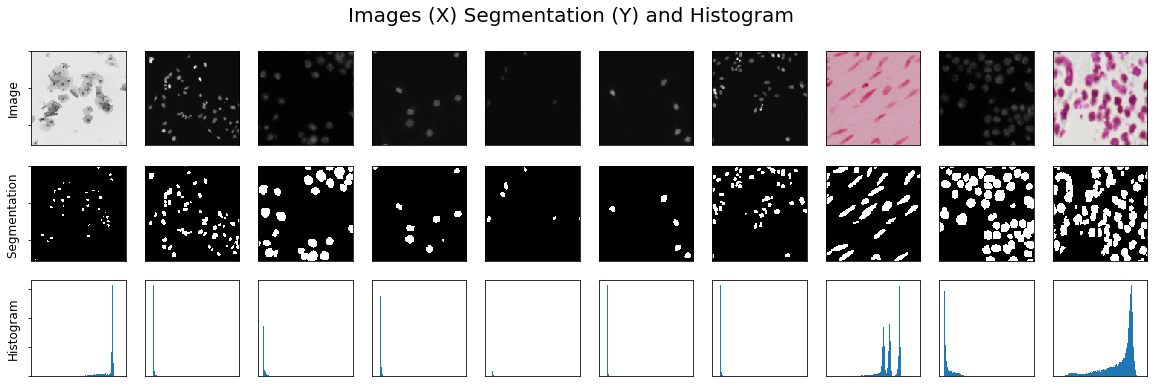

In [423]:
plot_original_data(indent = 25)

# Investigate Data

In [424]:
def scatter_images_plot(images, embedding, unique_labels, colors, labels, title = "UMAP embedding of images"):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = offsetbox.OffsetImage(img0, zoom=zoom)
            ab = offsetbox.AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.25, ax=ax)
            

    plot_embedding(embedding, X_train)
    plt.title(title, fontsize=20)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        class_member_mask = (labels == k)
        xy = embedding[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=50)

In [425]:
pca1 = PCA(n_components=2)
pca_regular_embedding = pca1.fit_transform([x.reshape(49152) for x in X_train])

In [426]:
regular_umap = umap.UMAP(n_neighbors=3)
regular_embedding = regular_umap.fit_transform([x.reshape(49152) for x in X_train])

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


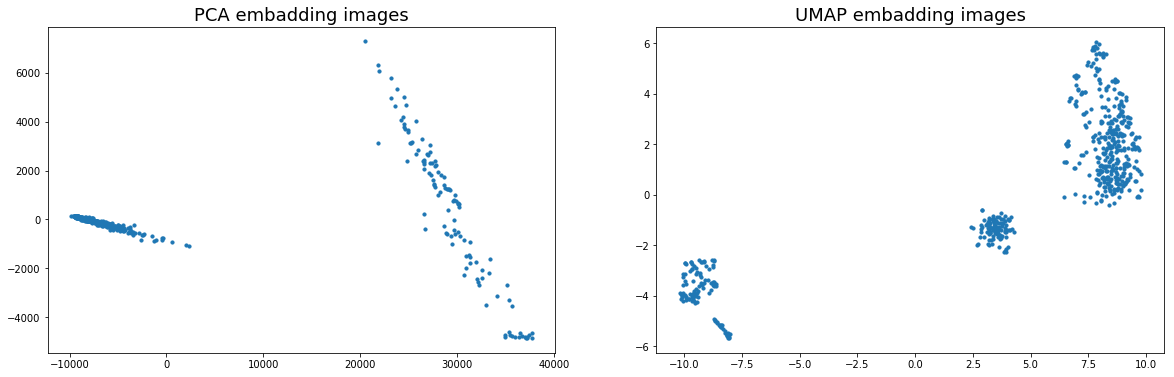

In [427]:
f, axarr = plt.subplots(1,2,figsize=(20,6))
axarr[0].scatter(pca_regular_embedding[:, 0], pca_regular_embedding[:, 1], s=10)
axarr[0].set_title("PCA embadding images", fontsize=18)
axarr[1].scatter(regular_embedding[:, 0], regular_embedding[:, 1], s=10)
axarr[1].set_title("UMAP embadding images", fontsize=18)
plt.show()


In [428]:
db = DBSCAN(eps=12000, min_samples=10).fit([x.reshape(49152) for x in X_train])
regular_labels = db.labels_

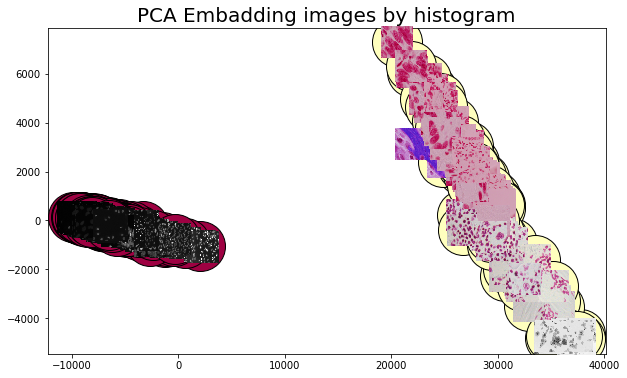

In [429]:
unique_labels = set(regular_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "PCA Embadding images by histogram"
scatter_images_plot(X_train, pca_regular_embedding, unique_labels, colors, regular_labels, title)

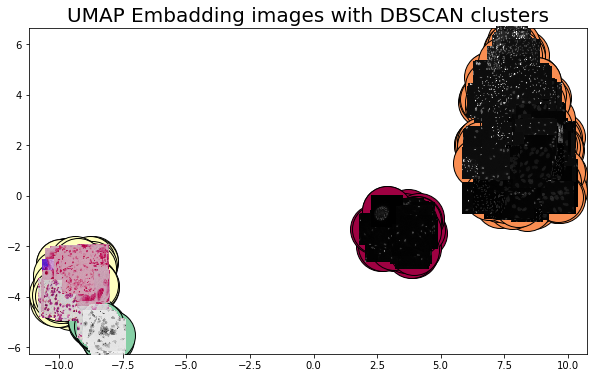

In [430]:
db = DBSCAN(eps=0.7, min_samples=10).fit(regular_embedding)
# db = DBSCAN(eps=6500, min_samples=10).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "UMAP Embadding images with DBSCAN clusters"
scatter_images_plot(X_train, regular_embedding, unique_labels, colors, labels, title)

In [431]:
def create_histogram_mapping(labels, X_train):
    hist_group = {}
    for index, (label, x_sample) in enumerate(zip(labels, X_train)):
        if label not in hist_group:
            hist_group[label] = []
        hist_group[label].append(index)
    return hist_group

In [432]:
def plot_clusters_images(hist_group, title):
    f, axarr = plt.subplots(6,len(hist_group.keys()),figsize=(20,10))

    for index, (_, sampels_indexes) in enumerate(hist_group.items()):
        for sample_index in range(0, 6, 2):
            indent = 2
            if sample_index + indent < len(sampels_indexes):
                axarr[sample_index,index].imshow(X_train[sampels_indexes[sample_index +indent ]])
                axarr[sample_index+1,index].hist(X_train[sampels_indexes[sample_index+indent ]].ravel(), bins=256, range=(0.0, 256.0))
            remove_axis(axarr[sample_index,index])
            remove_axis(axarr[sample_index+1,index])

        axarr[0,index].set_xlabel("group {} :{}#s".format(index, len(sampels_indexes)), rotation=0, size='large')
        axarr[0,index].xaxis.set_label_position('top') 
        axarr[0,index].get_xaxis().set_visible(True)
        axarr[0,index].set_xticklabels([])

    f.suptitle(title, fontsize=20)
    

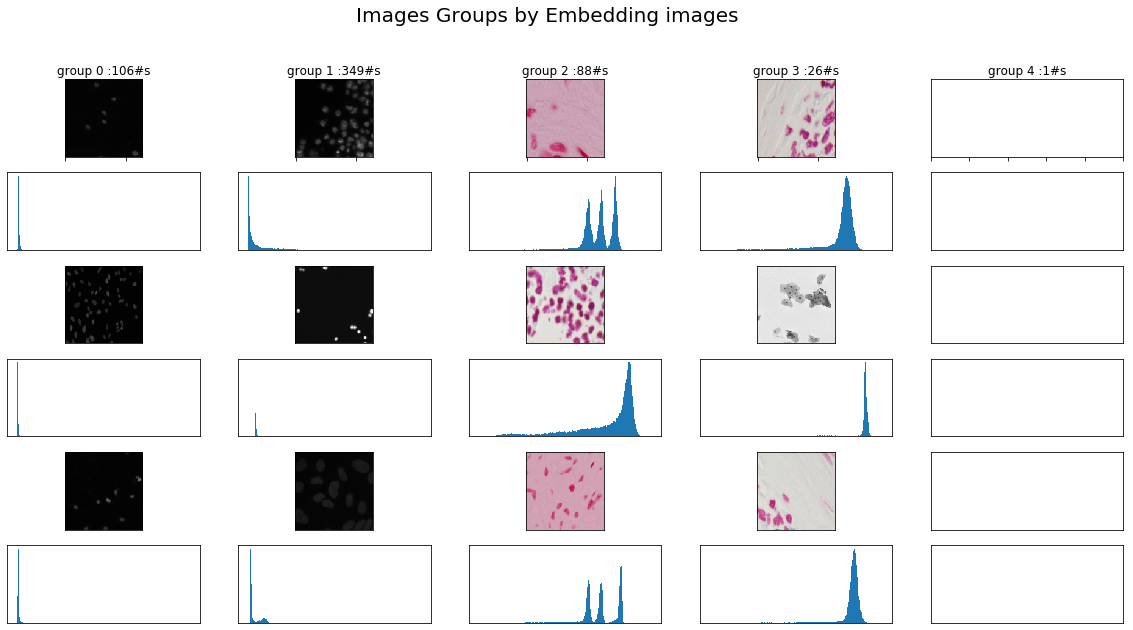

In [433]:
hist_group = create_histogram_mapping(labels, X_train)
plot_clusters_images(hist_group,"Images Groups by Embedding images")


## Group by Hist

In [434]:
X_train_hist = []
for i in range(0,len(X_train)):
    X_train_hist.append(np.histogram(X_train[i], bins=256, range=(0.0, 256.0)))

In [435]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform([x[0] for x in X_train_hist])

In [451]:
histogram_umap = umap.UMAP(n_neighbors=30,metric='correlation')
hist_embedding = histogram_umap.fit_transform([x[0] for x in X_train_hist])

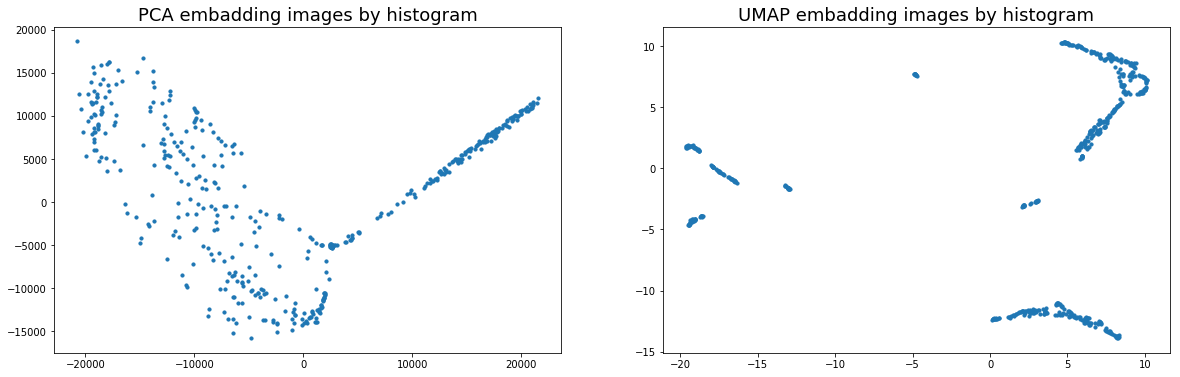

In [452]:
f, axarr = plt.subplots(1,2,figsize=(20,6))
axarr[0].scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=10)
axarr[0].set_title("PCA embadding images by histogram", fontsize=18)
axarr[1].scatter(hist_embedding[:, 0], hist_embedding[:, 1], s=10)
axarr[1].set_title("UMAP embadding images by histogram", fontsize=18)
plt.show()


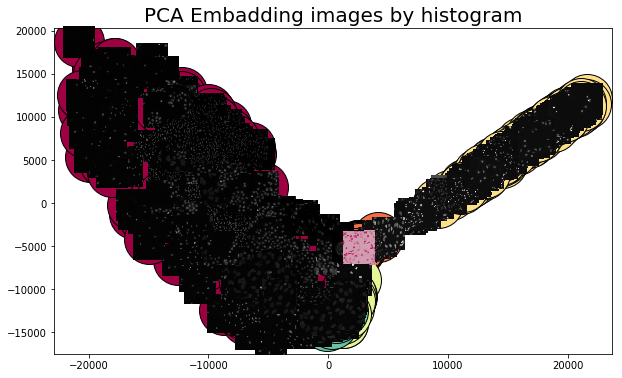

In [439]:
db = DBSCAN(eps=1000, min_samples=10).fit(pca_embedding)
db = DBSCAN(eps=6000, min_samples=10).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "PCA Embadding images by histogram"
scatter_images_plot(X_train, pca_embedding, unique_labels, colors, labels, title)

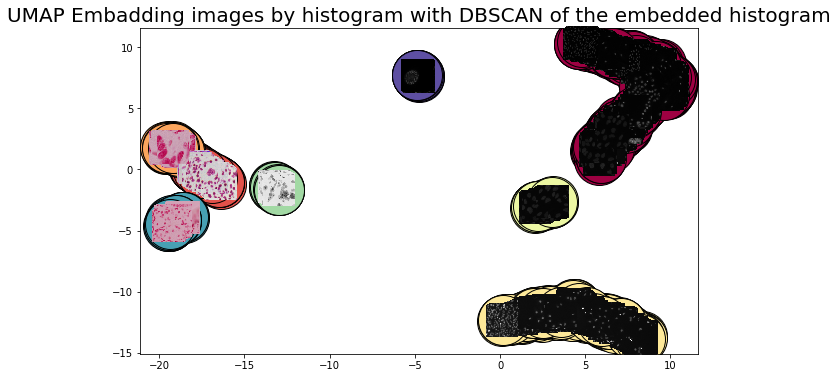

In [453]:
db = DBSCAN(eps=0.85, min_samples=10).fit(hist_embedding)
# db = DBSCAN(eps=10000, min_samples=30).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "UMAP Embadding images by histogram with DBSCAN of the embedded histogram"
scatter_images_plot(X_train, hist_embedding, unique_labels, colors, labels, title)

In [454]:
labels.shape, X_train.shape

((570,), (570, 128, 128, 3))

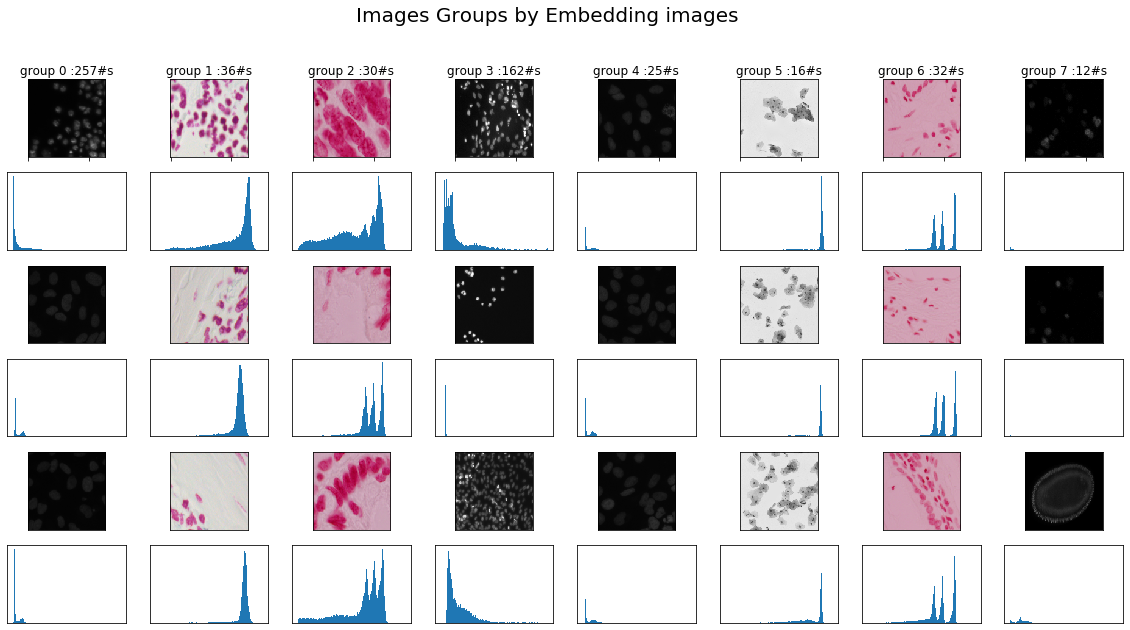

In [455]:
hist_group = create_histogram_mapping(labels, X_train)
plot_clusters_images(hist_group, "Images Groups by Embedding images")

# split train to validation set

In [497]:
VALIDATION_SPLIT = 0.1

0.1

In [517]:
factor = len(X_train)*VALIDATION_SPLIT
validation_set = []
validate_index = []
for key , items in hist_group.items():
    number_of_images =  round(factor*len(items)/len(X_train))
    validate_index.append(items[0])
    for i in range(0, number_of_images):
        validation_set.append(items[i])
validation_set = X_train[validation_set], Y_train[validation_set]

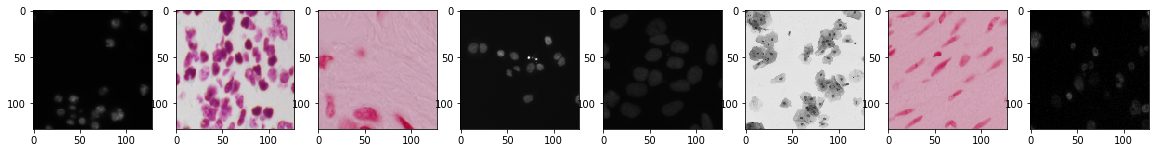

In [522]:
f, axarr = plt.subplots(1,len(validate_index),figsize=(20,10))
for i, image_i in enumerate(validate_index):
    axarr[i].imshow(X_train[image_i])
    

# SVM

### choose kernel

In [456]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


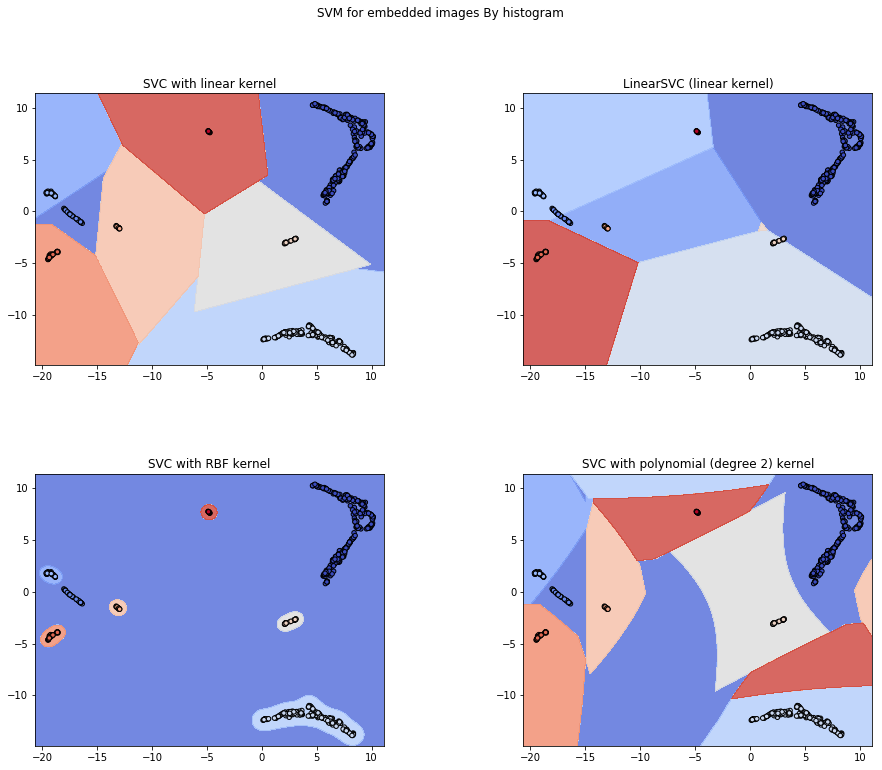

In [457]:
model_x = hist_embedding
model_y = db.labels_

C = 0.1  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=1.5, C=1),
          svm.SVC(kernel='poly', degree=2, C=C))

models = (clf.fit(model_x, model_y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 2) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(15, 12))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = model_x[:, 0], model_x[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=model_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(title)
    
fig.suptitle("SVM for embedded images By histogram")

plt.show()

### create a pipeline component

In [174]:
class HistogramEmbeddingSVM:
    def __init__(self, eps=0.85, min_samples=10, kernel='linear', C=0.1, n_neighbors=3, metric='correlation'):
        self.histogram_umap = umap.UMAP(n_neighbors=n_neighbors,metric='correlation')
        self.eps = eps
        self.min_samples = min_samples
        self.svm = svm.SVC(kernel=kernel, C=C)
          
    def transform(self, X):
        labels = predict(X)
        # TODO: add labels as channel or value to X
        return X, labels
    
    def fit_transform(self, X, Y=None):
        X_train_hist = [np.histogram(x, bins=256, range=(0.0, 256.0))[0] for x in X]
        hist_embedding = self.histogram_umap.fit_transform(X_train_hist)
        db = DBSCAN(eps=0.6, min_samples=10).fit(hist_embedding)
        self.svm.fit(hist_embedding, db.labels_)
        # TODO: add labels as channel or value to X
        return X, db.labels_
    
    def predict(self, X):
        X_train_hist = [np.histogram(x, bins=256, range=(0.0, 256.0))[0] for x in X]
        hist_embedding = self.histogram_umap.transform(X_train_hist)
        return self.svm.predict(hist_embedding)
    
        

In [181]:
hist_group_svm = HistogramEmbeddingSVM()
len(hist_group_svm.fit_transform(X_train))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 37 connected components using meta-embedding (experimental)
  n_components


2

In [185]:
x_test_group_dictionary = {}
for index, group_key in enumerate(hist_group_svm.predict(X_test)):
    if group_key not in x_test_group_dictionary:
        x_test_group_dictionary[group_key] = []
    x_test_group_dictionary[group_key].append(index)
        

In [186]:
for key, group in x_test_group_dictionary.items():
    print(key, len(group))

-1 77
4 6
6 5
12 9
0 3


## Thresholding Method

Text(0.5, 1.0, 'Mask')

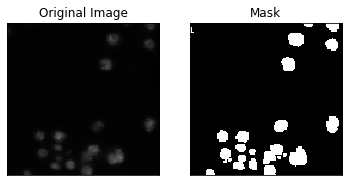

In [78]:
f, axarr = plt.subplots(1,2,figsize=(6,5))
axarr[0].imshow(X_train[0])
axarr[1].imshow(np.squeeze(Y_train[0]))
remove_axis(axarr[0])
remove_axis(axarr[1])
axarr[0].set_title("Original Image")
axarr[1].set_title("Mask")

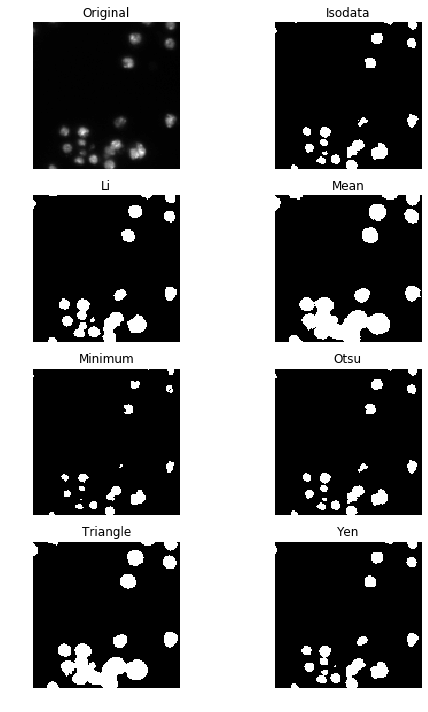

In [80]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(X_train[0][:, :, 0], figsize=(8, 10), verbose=False)
plt.show()

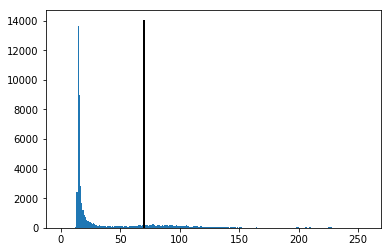

In [81]:
plt.hist(X_test[0].ravel(), bins=256, range=(0.0, 256.0))
plt.plot([70, 70], [0, 14000], 'k-', lw=2)
plt.show()

In [82]:
X_test[0].ravel().shape

(49152,)

### Threshold Yen

In [83]:
def simple_th(image):
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    return thresh ,binary
    

In [85]:
from skimage.filters import threshold_yen

def plot_threshold_yen(i=0, th_method = simple_th):
    image = X_train[i][:, :, 0]
    thresh ,binary = th_method(image)
    f, axarr = plt.subplots(1,4,figsize=(15,3))
    axarr[0].imshow(X_train[i])
    axarr[0].set_title("Original nuclei image")
    axarr[2].imshow(np.squeeze(Y_train[i]))
    axarr[2].set_title("Image segmentation (ground truth)")
    axarr[1].imshow(binary)
    axarr[1].set_title("Yen threshold")
    if th_method == dumb_th:
        axarr[1].set_title("Arbitrary 50 threshold")
    
    x_ravel = np.histogram(X_train[i].ravel(), bins=256, range=(0.0, 256.0))
    
    axarr[3].hist(X_train[i].ravel(), bins=256, range=(0.0, 256.0))
    axarr[3].plot([thresh, thresh], [0, max(x_ravel[0])], 'k-', lw=2)
    axarr[3].set_title("histogram")
    
    for i in range(0,3):
        remove_axis(axarr[i])
    axarr[3].get_yaxis().set_visible(False)


In [86]:
def dumb_th(image):
    thresh = 50
    binary = np.array( image > thresh, dtype=int)
    return thresh ,binary

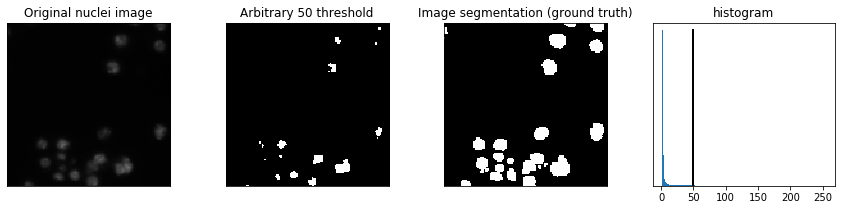

In [87]:
plot_threshold_yen(i=0, th_method=dumb_th)

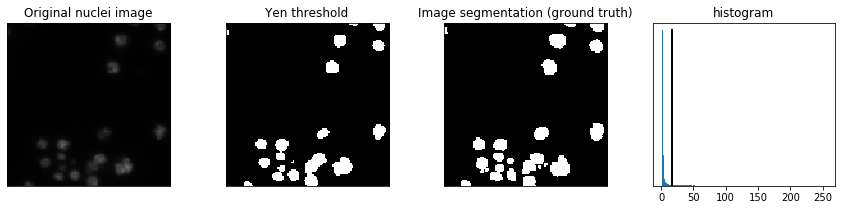

In [88]:
plot_threshold_yen(i=0)

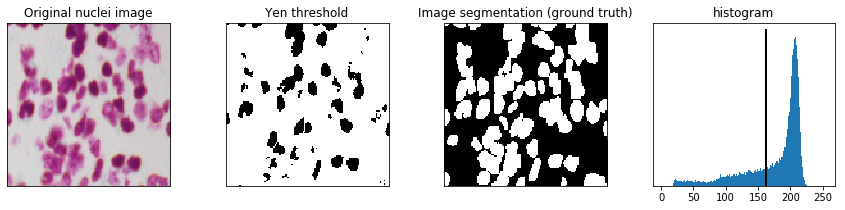

In [89]:
plot_threshold_yen(i=2)

In [90]:
def smart_thresholding(image , th_method = threshold_yen):
    thresh = th_method(image)
    
    x_ravel = np.histogram(image.ravel(), bins=256, range=(0.0, 256.0))
    max_index = list(x_ravel[0]).index(max(x_ravel[0]))
    max_value, max_th = (x_ravel[0][max_index], x_ravel[1][max_index])
    
    if max_th < thresh:
        binary = np.array( image > thresh, dtype=int)
    else:
        binary = np.array( image < thresh, dtype=int)
        
    return thresh ,binary


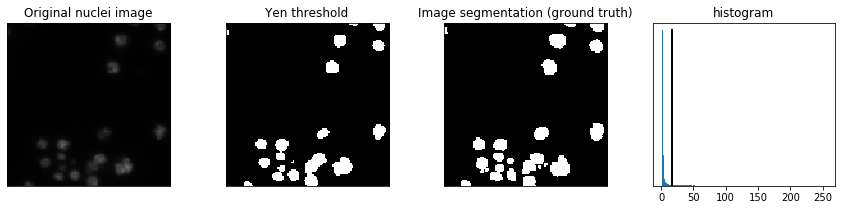

In [91]:
plot_threshold_yen(i=0,th_method=smart_thresholding)

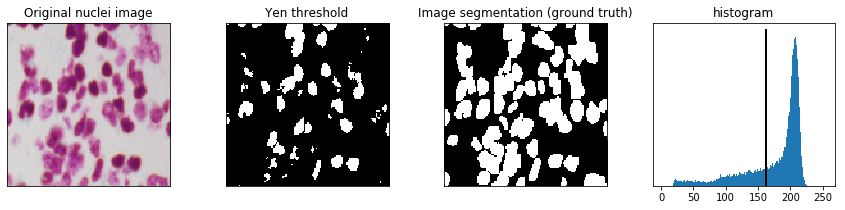

In [92]:
plot_threshold_yen(i=2,th_method=smart_thresholding)

In [93]:
image = X_test[0][:, :, 0]
thresh ,binary = smart_thresholding(image)
simple_iou(binary,np.squeeze(Y_test[0]))

0.895152198421646

In [135]:
iou_sum = 0
len1 = 0
for i in range(0,100):
    image = X_test[i][:, :, 0]
    thresh ,binary = smart_thresholding(image)
    iou_sum += simple_iou(binary,np.squeeze(Y_test[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.6961107421063497 100


### Threshold Otsu

In [136]:
iou_sum = 0
len1 = 0
for i in range(0,100):
    image = X_test[i][:, :, 0]
    thresh ,binary = smart_thresholding(image, th_method=threshold_otsu)
    iou_sum += simple_iou(binary,np.squeeze(Y_test[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.7188591354594833 100


## Show IoU idea

Text(0.5, 0.98, 'IOU example')

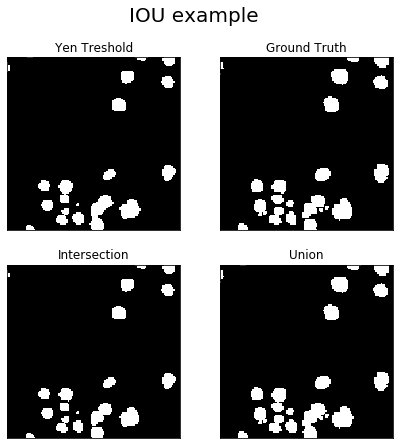

In [96]:

image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
component1 = np.array( image > thresh, dtype=int)
component2 = np.squeeze(Y_train[0])

overlap = component1*component2
iou = component1 + component2
union = (iou > 0).astype(np.uint8)

f, axarr = plt.subplots(2,2,figsize=(7,7))
axarr[0,0].set_title("Yen Treshold")
axarr[0,0].imshow(component1)
axarr[0,1].set_title("Ground Truth")
axarr[0,1].imshow(component2)
axarr[1,0].set_title("Intersection")
axarr[1,0].imshow(overlap)
axarr[1,1].set_title("Union")
axarr[1,1].imshow(union)

for i in range(0,2):
    for j in range(0,2):
        remove_axis(axarr[i,j])
f.suptitle("IOU example", fontsize=20)

Text(0.5, 0.98, 'IOU example')

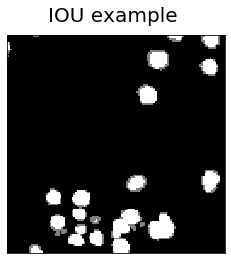

In [97]:
f, axarr = plt.subplots(1,1,figsize=(4,4))
axarr.imshow(iou)
remove_axis(axarr)
f.suptitle("IOU example", fontsize=20)

Text(0.5, 0.98, 'IOU score per threshold')

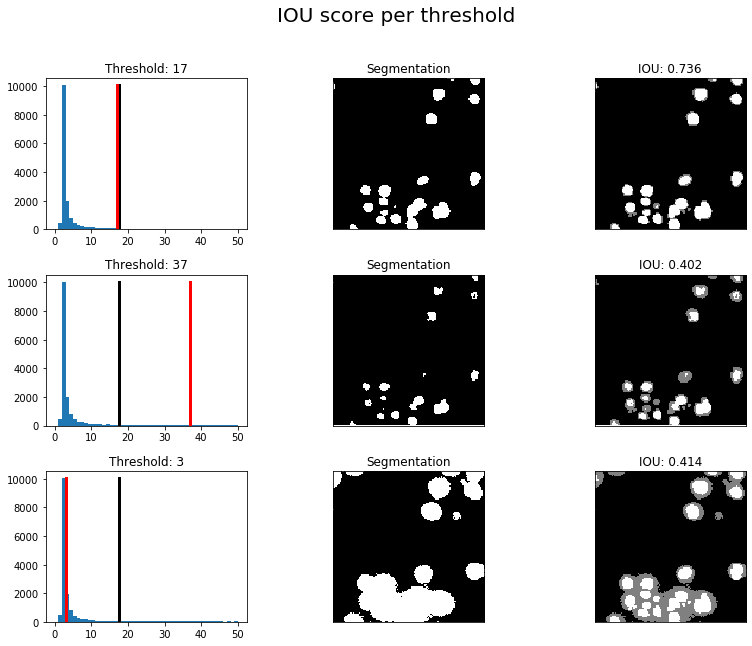

In [98]:


image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
component2 = np.squeeze(Y_train[0])
thresholds = [("Threshold: {}".format(thresh), thresh),
             ("Threshold: {}".format(thresh+20), thresh+20),
             ("Threshold: {}".format(3), 3)]

x_ravel = np.histogram(image.ravel(), bins=256, range=(0.0, 256.0))

f, axarr = plt.subplots(3,3,figsize=(13,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, (title, th) in enumerate(thresholds):
    component1 = np.array( image > th, dtype=int)
    iou = component1 + component2
    iou_value =  simple_iou(component1,component2)
    
    axarr[i,1].imshow(component1)
    axarr[i,1].set_title("Segmentation")
    remove_axis(axarr[i,1])
    
    axarr[i,2].imshow(iou)
    axarr[i,2].set_title("IOU: {:.{}f}".format(iou_value,3))
    remove_axis(axarr[i,2])
    

    axarr[i,0].set_title(title)
    axarr[i,0].hist(image.ravel(), bins=50, range=(0.0, 50.0))
    axarr[i,0].plot([17.5, 17.5], [0, max(x_ravel[0])], 'k-', lw=3)
    axarr[i,0].plot([th, th], [0, max(x_ravel[0])], 'r-', lw=3)

    axarr[i,2].get_yaxis().set_visible(False)
#     axarr[3].set_title("histogram")
f.suptitle("IOU score per threshold", fontsize=20)


# KERAS Models

### models names:

In [458]:
FCN_model_name = 'FCN-v'
Unet_model_name = 'U-net-v'
large_Unet_model_name = 'large-U-net-v'

In [459]:
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.1
EPOCHS = 100
START_LR = 1e-3
END_LR = 1e-4

### calc learning rate decay step:

In [460]:
number_of_updates = round(round(number_of_train_samples*(1-VALIDATION_SPLIT))*EPOCHS/BATCH_SIZE)
LR_DECAY = (START_LR - END_LR)/number_of_updates
LR_DECAY

1.40361821584529e-07

## FCN

In [462]:
def FCN_v1(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)
    model = Model(input = inputs, output = conv)
    return model 

In [418]:
FCN_v1().summary()

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 128, 128, 4)       292       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 128, 128, 2)       74        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 1)       3         
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


In [552]:
    
model = FCN_v1()
model.compile(optimizer = Adam(lr= START_LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "FCN_v2_LR{}.h5".format(START_LR)

epochs_=100

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    
results = model.fit(X_train, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochs_, 
                    verbose=0,
                    callbacks=[earlystopper, checkpointer])

# decoder.save("decoder_{}".format(model_name))
# encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  



Epoch 00001: val_loss improved from inf to 0.70688, saving model to FCN_v2_LR0.001.h5

Epoch 00002: val_loss improved from 0.70688 to 0.64412, saving model to FCN_v2_LR0.001.h5

Epoch 00003: val_loss improved from 0.64412 to 0.61447, saving model to FCN_v2_LR0.001.h5

Epoch 00004: val_loss improved from 0.61447 to 0.59229, saving model to FCN_v2_LR0.001.h5

Epoch 00005: val_loss improved from 0.59229 to 0.57423, saving model to FCN_v2_LR0.001.h5

Epoch 00006: val_loss improved from 0.57423 to 0.52342, saving model to FCN_v2_LR0.001.h5

Epoch 00007: val_loss improved from 0.52342 to 0.47169, saving model to FCN_v2_LR0.001.h5

Epoch 00008: val_loss improved from 0.47169 to 0.45845, saving model to FCN_v2_LR0.001.h5

Epoch 00009: val_loss improved from 0.45845 to 0.44641, saving model to FCN_v2_LR0.001.h5

Epoch 00010: val_loss improved from 0.44641 to 0.39743, saving model to FCN_v2_LR0.001.h5

Epoch 00011: val_loss improved from 0.39743 to 0.37014, saving model to FCN_v2_LR0.001.h5

Ep

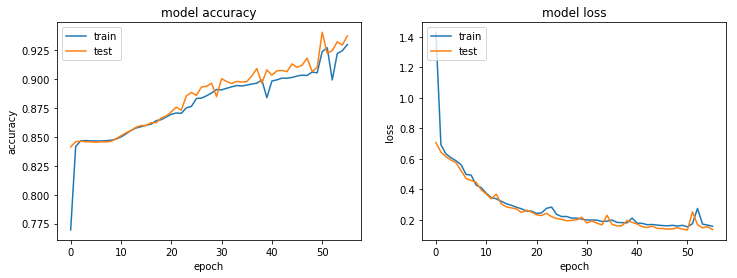

In [553]:
f, axarr = plt.subplots(1,2,figsize=(12,4))
for i, train_v, test_v, metric in [(0, 'acc','val_acc', 'accuracy'),(1, 'loss', 'val_loss', 'loss')]:
    axarr[i].plot(results.history[train_v])
    axarr[i].plot(results.history[test_v])
    axarr[i].set_title('model {}'.format(metric))
    axarr[i].set_ylabel(metric)
    axarr[i].set_xlabel('epoch')
    axarr[i].legend(['train', 'test'], loc='upper left')

start investigate_iou:  FCN_v2_LR0.001.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 9ms/step

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7117408125817977  number of samples:  100
mean train IOU:  0.7019783829818611  number of samples:  570

train threshold:  0.43175438596491206  test threshold:  0.4499

 best traning threshold to use:  0.43175438596491206

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7381347267693156  number of samples:  100
mean train IOU:  0.7065170356913636  number of samples:  570


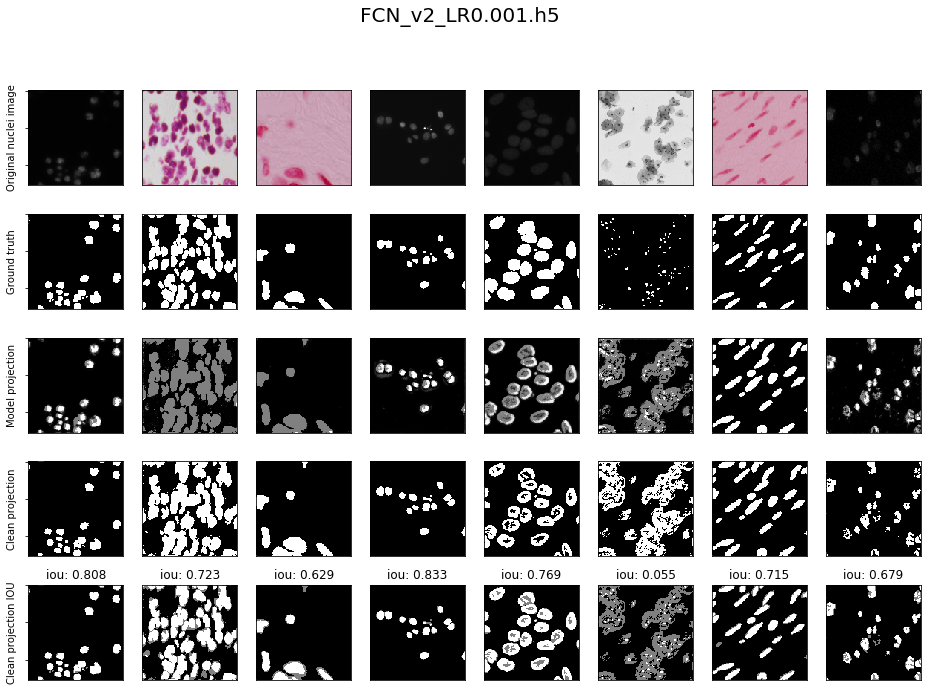

In [554]:
model_name = 'FCN_v2_LR0.001.h5'
investigate_iou(model_name)

## U-net

In [463]:

def Contracting(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv )
    return pool , conv

def Expansive(inputs, parallel_conv, dim):
    up = Conv2D(dim, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inputs))
    
    merge_l = concatenate([parallel_conv,up], axis=3)
#     merge_l = merge([parallel_conv,up], mode = 'concat', concat_axis = 3)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_l)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    return conv

def Conv_n_Dropout(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(0.5 ,  name='decoder')(conv)
    return drop
    

In [464]:
def unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 in order to test it on my own cpu 
    i also excluded one pooling group 
    """
    inputs = Input(input_size)
    contract4, conv4 = Contracting(inputs, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    convolve_n_drop32 = Conv_n_Dropout(contract16, 32)
    expan16 = Expansive(convolve_n_drop32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    model = Model(inputs = inputs, outputs = conv1)

    return model

In [253]:
model = unet()
model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "{}_LR_DECAY_from_{}_to_{}.h5".format(Unet_model_name, START_LR, END_LR)
print(model_name)
train_keras_model(model,model_name, epochs_=100)

U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00000: val_loss improved from inf to 0.30739, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.30739 to 0.26827, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.26827 to 0.22208, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.22208 to 0.21183, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.21183 to 0.20723, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.20723 to 0.20297, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.20297 to 0.20207, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.20207 to 0.2

## large unet Model

In [465]:
def large_unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 -> 64 in order to test it on my own cpu 
    """
    inputs = Input(input_size)
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting(lambda1, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    contract32, conv32 = Contracting(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan16 = Expansive(expan32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)
    
#     print([x.name for x in autoencoder.layers])
    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [466]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "large_unet_v2_LR_DECAY_from_{}_to_{}.h5".format(START_LR, END_LR)

train_keras_model(model, model_name, epochs_=100)

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 00001: val_loss improved from inf to 0.44271, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00002: val_loss improved from 0.44271 to 0.42314, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00003: val_loss improved from 0.42314 to 0.38444, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00004: val_loss improved from 0.38444 to 0.29575, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00005: val_loss improved from 0.29575 to 0.21252, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00006: val_loss improved from 0.21252 to 0.17037, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00007: val_loss improved from 0.17037 to 0.14256, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00008: val_loss improved from 0.14256 to 0.13895, saving model to large_unet_v2_LR_DECAY_from_0.001_to_0.0001.h5

Epoch 00009: val_loss improved from 0.13895

In [515]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "large_unet_v3_vd_LR{}.h5".format(START_LR)

epochs_=100

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    
results = model.fit(X_train, Y_train, 
                    validation_data = validation_set,
                    batch_size=BATCH_SIZE, 
                    epochs=epochs_, 
                    verbose=0,
                    callbacks=[earlystopper, checkpointer])

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 00001: val_loss improved from inf to 0.39876, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00002: val_loss improved from 0.39876 to 0.26481, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00003: val_loss improved from 0.26481 to 0.20983, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00004: val_loss improved from 0.20983 to 0.19660, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00005: val_loss improved from 0.19660 to 0.17567, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00006: val_loss improved from 0.17567 to 0.16788, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00007: val_loss improved from 0.16788 to 0.16672, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00008: val_loss improved from 0.16672 to 0.15952, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00009: val_loss improved from 0.15952 to 0.15662, saving model to large_unet_v3_vd_LR0.001.h5

Epoch 00010: val_loss did not improve from 0.15662

Epoch 00011: val_loss improved from 0.1566

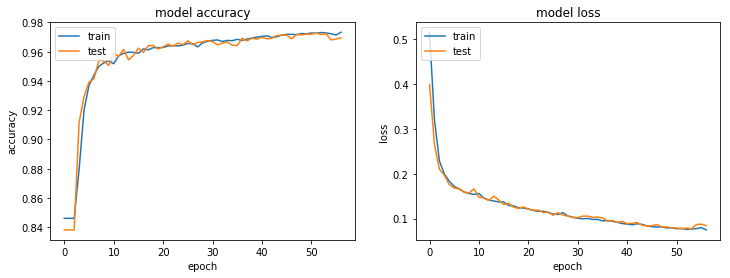

In [520]:
f, axarr = plt.subplots(1,2,figsize=(12,4))
for i, train_v, test_v, metric in [(0, 'acc','val_acc', 'accuracy'),(1, 'loss', 'val_loss', 'loss')]:
    axarr[i].plot(results.history[train_v])
    axarr[i].plot(results.history[test_v])
    axarr[i].set_title('model {}'.format(metric))
    axarr[i].set_ylabel(metric)
    axarr[i].set_xlabel('epoch')
    axarr[i].legend(['train', 'test'], loc='upper left')

start investigate_iou:  large_unet_v3_vd_LR0.001.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s 19ms/step

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.8075348629184371  number of samples:  100
mean train IOU:  0.8276250457825972  number of samples:  570

train threshold:  0.5480350877192981  test threshold:  0.5086999999999999

 best traning threshold to use:  0.5480350877192981

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.8218275476316186  number of samples:  100
mean train IOU:  0.8360896228871717  number of samples:  570


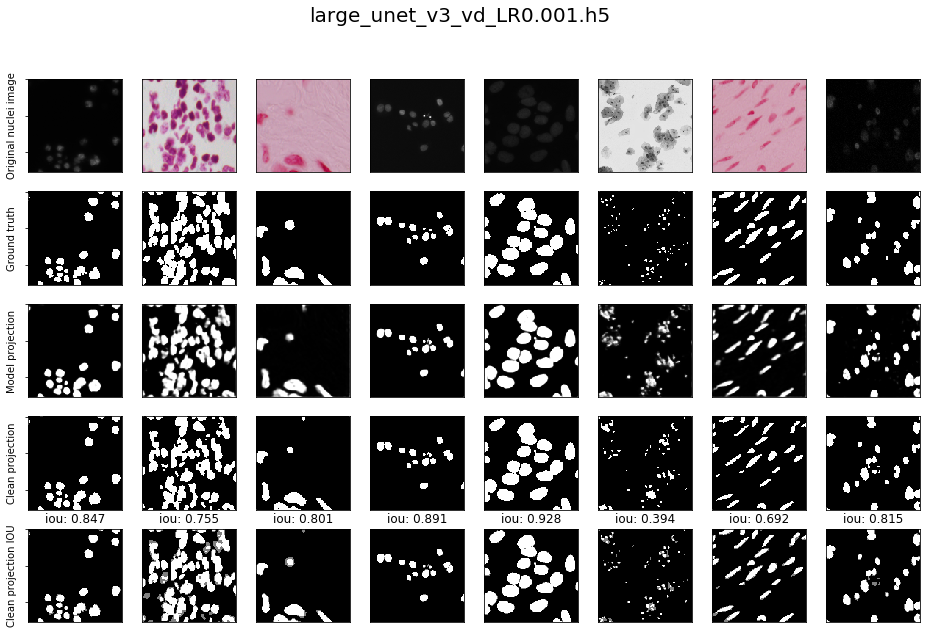

In [549]:
model_name = 'large_unet_v3_vd_LR0.001.h5'
investigate_iou(model_name)

In [467]:
    
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "large_unet_v2_LR{}.h5".format(START_LR)

epochs_=100

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    
results = model.fit(X_train, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochs_, 
                    verbose=0,
                    callbacks=[earlystopper, checkpointer])

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 00001: val_loss improved from inf to 0.29586, saving model to large_unet_v2_LR0.001.h5

Epoch 00002: val_loss improved from 0.29586 to 0.20627, saving model to large_unet_v2_LR0.001.h5

Epoch 00003: val_loss improved from 0.20627 to 0.16956, saving model to large_unet_v2_LR0.001.h5

Epoch 00004: val_loss improved from 0.16956 to 0.12203, saving model to large_unet_v2_LR0.001.h5

Epoch 00005: val_loss improved from 0.12203 to 0.10493, saving model to large_unet_v2_LR0.001.h5

Epoch 00006: val_loss did not improve from 0.10493

Epoch 00007: val_loss improved from 0.10493 to 0.09866, saving model to large_unet_v2_LR0.001.h5

Epoch 00008: val_loss improved from 0.09866 to 0.09330, saving model to large_unet_v2_LR0.001.h5

Epoch 00009: val_loss improved from 0.09330 to 0.09049, saving model to large_unet_v2_LR0.001.h5

Epoch 00010: val_loss did not improve from 0.09049

Epoch 00011: val_loss improved from 0.09049 to 0.08209, saving model to large_unet_v2_LR0.001.h5

Epoch 00012: val_

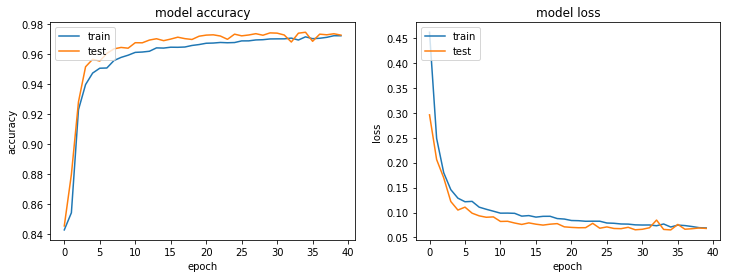

In [486]:
f, axarr = plt.subplots(1,2,figsize=(12,4))
for i, train_v, test_v, metric in [(0, 'acc','val_acc', 'accuracy'),(1, 'loss', 'val_loss', 'loss')]:
    axarr[i].plot(results.history[train_v])
    axarr[i].plot(results.history[test_v])
    axarr[i].set_title('model {}'.format(metric))
    axarr[i].set_ylabel(metric)
    axarr[i].set_xlabel('epoch')
    axarr[i].legend(['train', 'test'], loc='upper left')

start investigate_iou:  large_unet_v2_LR0.001.h5
570/570 [==============================] - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 12s 20ms/step

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.8187725890757435  number of samples:  100
mean train IOU:  0.8216925279912703  number of samples:  570

train threshold:  0.4613333333333329  test threshold:  0.4501000000000001

 best traning threshold to use:  0.4613333333333329

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.8251967977668287  number of samples:  100
mean train IOU:  0.8220362160991201  number of samples:  570


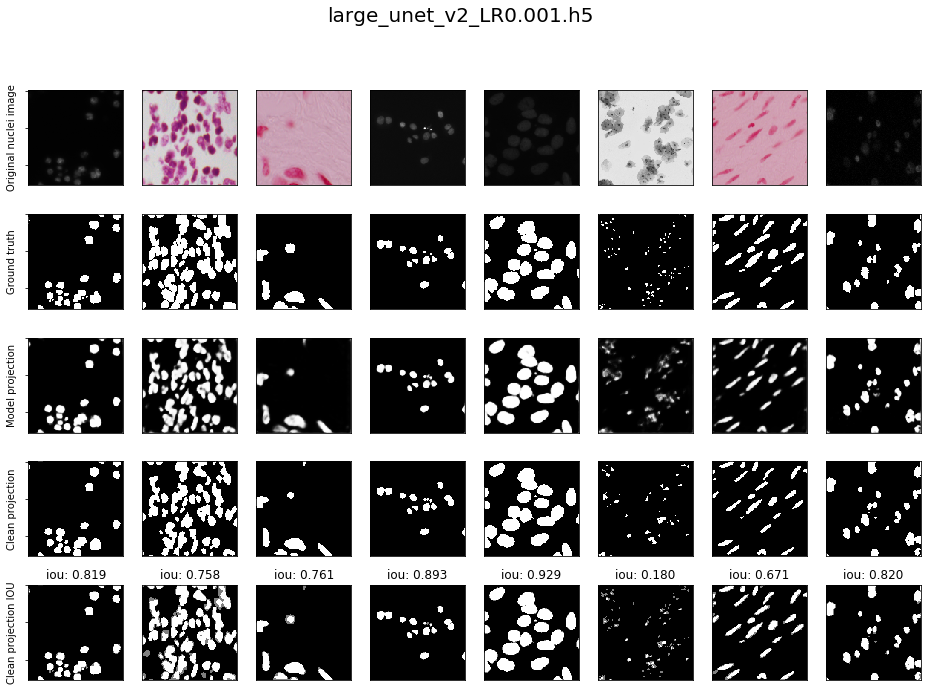

In [551]:
model_name = 'large_unet_v2_LR0.001.h5'
investigate_iou(model_name)

In [ ]:
uplot.drow_history(results, 'loss')

In [470]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= END_LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "large_unet_v2_LR{}.h5".format(END_LR)

epochs_=100

earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    
results2 = model.fit(X_train, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochs_, 
                    verbose=0,
                    callbacks=[earlystopper, checkpointer])

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 00001: val_loss improved from inf to 0.51572, saving model to large_unet_v2_LR0.0001.h5

Epoch 00002: val_loss improved from 0.51572 to 0.37777, saving model to large_unet_v2_LR0.0001.h5

Epoch 00003: val_loss improved from 0.37777 to 0.32956, saving model to large_unet_v2_LR0.0001.h5

Epoch 00004: val_loss improved from 0.32956 to 0.29698, saving model to large_unet_v2_LR0.0001.h5

Epoch 00005: val_loss improved from 0.29698 to 0.27906, saving model to large_unet_v2_LR0.0001.h5

Epoch 00006: val_loss improved from 0.27906 to 0.25159, saving model to large_unet_v2_LR0.0001.h5

Epoch 00007: val_loss improved from 0.25159 to 0.23952, saving model to large_unet_v2_LR0.0001.h5

Epoch 00008: val_loss improved from 0.23952 to 0.23177, saving model to large_unet_v2_LR0.0001.h5

Epoch 00009: val_loss improved from 0.23177 to 0.22419, saving model to large_unet_v2_LR0.0001.h5

Epoch 00010: val_loss improved from 0.22419 to 0.21918, saving model to large_unet_v2_LR0.0001.h5

Epoch 00011: 

Epoch 00090: val_loss improved from 0.13292 to 0.13275, saving model to large_unet_v2_LR0.0001.h5

Epoch 00091: val_loss improved from 0.13275 to 0.13225, saving model to large_unet_v2_LR0.0001.h5

Epoch 00092: val_loss improved from 0.13225 to 0.13198, saving model to large_unet_v2_LR0.0001.h5

Epoch 00093: val_loss did not improve from 0.13198

Epoch 00094: val_loss improved from 0.13198 to 0.13154, saving model to large_unet_v2_LR0.0001.h5

Epoch 00095: val_loss improved from 0.13154 to 0.13080, saving model to large_unet_v2_LR0.0001.h5

Epoch 00096: val_loss improved from 0.13080 to 0.13030, saving model to large_unet_v2_LR0.0001.h5

Epoch 00097: val_loss improved from 0.13030 to 0.12986, saving model to large_unet_v2_LR0.0001.h5

Epoch 00098: val_loss improved from 0.12986 to 0.12871, saving model to large_unet_v2_LR0.0001.h5

Epoch 00099: val_loss did not improve from 0.12871

Epoch 00100: val_loss improved from 0.12871 to 0.12842, saving model to large_unet_v2_LR0.0001.h5


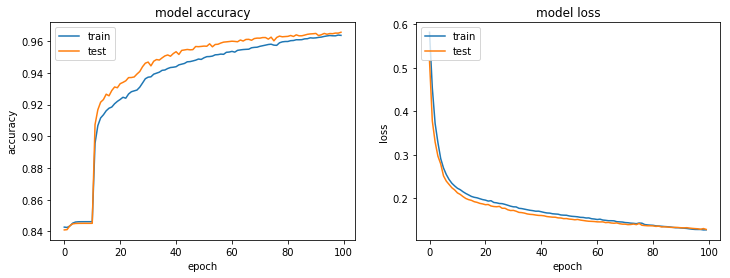

In [488]:
f, axarr = plt.subplots(1,2,figsize=(12,4))
for i, train_v, test_v, metric in [(0, 'acc','val_acc', 'accuracy'),(1, 'loss', 'val_loss', 'loss')]:
    axarr[i].plot(results2.history[train_v])
    axarr[i].plot(results2.history[test_v])
    axarr[i].set_title('model {}'.format(metric))
    axarr[i].set_ylabel(metric)
    axarr[i].set_xlabel('epoch')
    axarr[i].legend(['train', 'test'], loc='upper left')

start investigate_iou:  large_unet_v2_LR0.0001.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 18ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.39905733032868257  number of samples:  100
mean train IOU:  0.392365072994118  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7515974001165577  number of samples:  100
mean train IOU:  0.767487732230909  number of samples:  570

train threshold:  0.4472105263157894  test threshold:  0.44549999999999995

 best traning threshold to use:  0.44549999999999995

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7792826299139033  number of samples:  100
mean train IOU:  0.78451520093122  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


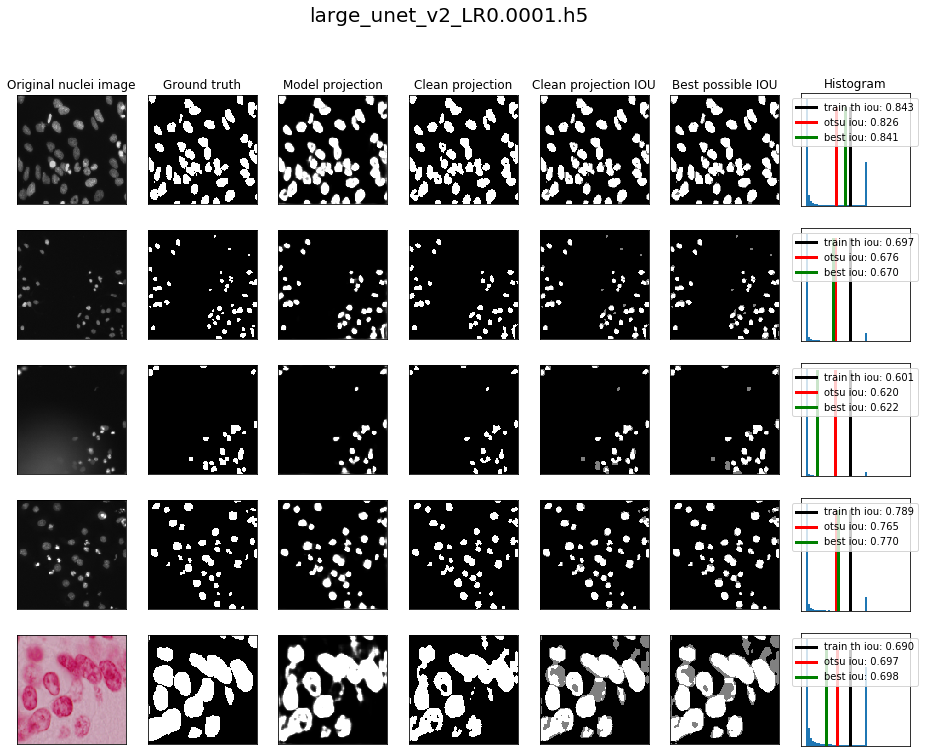

In [496]:
model_name = 'large_unet_v2_LR0.0001.h5'
investigate_iou(model_name)

## Model Evaluation Utils

In [491]:
def find_best_threshold(pred_data, compared_data, res = 101):
    if len(pred_data) != len(compared_data):
        raise Exception("invalid compared shapes, {} != {}".format(len(pred_data),len(compared_data)))
    thresholds = []
    for i in range(0,len(pred_data)):
        best_t = 0
        best_iou = 0
        for t in np.linspace(0,1,res):
            iou = simple_iou(np.squeeze(pred_data[i]> t),np.squeeze(compared_data[i]))
            if iou > best_iou:
                best_iou = iou
                best_t = t
        thresholds.append(best_t)
    return sum(thresholds) / float(len(thresholds))

In [265]:
def get_threshold_local(preds_train, preds_test):
    best_train_th = find_best_threshold(preds_train, Y_train)
    best_test_th = find_best_threshold(preds_test, Y_test)
    print("\ntrain threshold: " , best_train_th, " test threshold: ", best_test_th )
    if  best_train_th - best_test_th > 0.001:
        print("WARNING: model best threshold is not efficient, bias: {}".format(best_train_th - best_test_th))
    return best_train_th, best_test_th

In [363]:
def get_model_mean_iou_local(preds_test_th, preds_train_th):
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_test)):
        iou_sum += simple_iou(np.squeeze(preds_test_th[i]),np.squeeze(Y_test[i]))
        len1 += 1
    print("mean test IOU: ", iou_sum/ len1, " number of samples: ", len1)
    
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_train)):
        iou_sum += simple_iou(np.squeeze(preds_train_th[i]),np.squeeze(Y_train[i]))
        len1 += 1
    print("mean train IOU: ", iou_sum/ len1, " number of samples: ", len1)
    

In [365]:
def np_smart_threshold(image, th_method=threshold_yen):
    _ ,binary = smart_thresholding(image, th_method=th_method)
    return binary

In [528]:

def predict_segmentetion_plot_local(model_name,  preds_test, preds_test_th, best_th, number_of_plots = 2):
    f, axarr = plt.subplots(len(validate_index) ,7,figsize=(16,12))
    for i,(image_index) in enumerate(validate_index):
        
        image = X_test[image_index]
        mask = np.squeeze(Y_test[image_index])
        predicted = np.squeeze(preds_test[image_index])
        b_predicted = np.squeeze(preds_test_th[image_index])
    
        axarr[i,0].imshow(image)
        axarr[i,1].imshow(mask)
        axarr[i,2].imshow(predicted)
        axarr[i,3].imshow(b_predicted)
        
        iou = mask + b_predicted
        
        axarr[i,4].imshow(iou)
        
        x_ravel = np.histogram(predicted.ravel(), bins=256, range=(0.0, 1.0))
        otsu_th ,_ = smart_thresholding(predicted,th_method=threshold_otsu)
        otsu_image = (predicted > otsu_th).astype(np.uint8)
        
        best_possible_th = find_best_threshold(predicted, mask, res=5001)

        best_possible_prediction = (predicted > best_possible_th).astype(np.uint8)
        best_possible_iou = mask + best_possible_prediction
        
        b_predicted_iou_score = "train th iou: {:.{}f}".format(simple_iou(b_predicted, mask),3)
        otsu_iou_score = "otsu iou: {:.{}f}".format(simple_iou(otsu_image, mask),3)
        best_possible_iou_score = "best iou: {:.{}f}".format(simple_iou(best_possible_prediction, mask),3)

        axarr[i,5].imshow(best_possible_iou)
        
        axarr[i,6].hist(predicted.ravel(), bins=50, range=(-0.01, 1.01))
        
        axarr[i,6].plot([best_th, best_th], [0, max(x_ravel[0])], 'k-', lw=3, label=b_predicted_iou_score)
        axarr[i,6].plot([otsu_th, otsu_th], [0, max(x_ravel[0])], 'r-', lw=3, label=otsu_iou_score)
        axarr[i,6].plot([best_possible_th, best_possible_th], [0, max(x_ravel[0])], 'g-', lw=3, label=best_possible_iou_score)
        
        axarr[i,6].yaxis.tick_right()
        axarr[i,6].legend(loc="upper center")

        for j in range(0,7):
            remove_axis(axarr[i,j])
        
        axarr[0,0].set_title("Original nuclei image")
        axarr[0,1].set_title("Ground truth")
        axarr[0,2].set_title("Model projection")
        axarr[0,3].set_title("Clean projection")
        axarr[0,4].set_title("Clean projection IOU")
        axarr[0,5].set_title("Best possible IOU")
        axarr[0,6].set_title("Histogram")

    return f, axarr

In [550]:
def predict_segmentetion_plot_local(model_name,  preds_train, preds_train_th, best_th, number_of_plots = 2):
    f, axarr = plt.subplots(5,len(validate_index),figsize=(16,11))
    for i,(image_index) in enumerate(validate_index):
        
        image = X_train[image_index]
        mask = np.squeeze(Y_train[image_index])
        predicted = np.squeeze(preds_train[image_index])
        b_predicted = np.squeeze(preds_train_th[image_index])
    
        axarr[0,i].imshow(image)
        axarr[1,i].imshow(mask)
        axarr[2,i].imshow(predicted)
        axarr[3,i].imshow(b_predicted)
        
        iou = mask + b_predicted
        
        axarr[4,i].imshow(iou)
        
        b_predicted_iou_score = "iou: {:.{}f}".format(simple_iou(b_predicted, mask),3)
        
        
        for j in range(0,5):
            remove_axis(axarr[j,i])
            
        axarr[4,i].set_title(b_predicted_iou_score)
        
        axarr[0,0].set_ylabel("Original nuclei image")
        axarr[1,0].set_ylabel("Ground truth")
        axarr[2,0].set_ylabel("Model projection")
        axarr[3,0].set_ylabel("Clean projection")
        axarr[4,0].set_ylabel("Clean projection IOU")
        for j in range(0,5):
            axarr[j,0].get_yaxis().set_visible(True)
            axarr[j,0].set_yticklabels([])
               
            
    return f, axarr

In [541]:
for j in range(0,5):
    j

In [532]:
def investigate_iou(model_name):
    print('start investigate_iou: ', model_name)
    model = load_model(model_name)
    preds_test = model.predict(X_test, verbose=1)
    preds_train = model.predict(X_train, verbose=1)
    
#     preds_train_th = np.apply_along_axis(lambda x: np_smart_threshold(x,th_method=threshold_yen), 0, preds_train)
#     preds_test_th = np.apply_along_axis(lambda x: np_smart_threshold(x,th_method=threshold_yen), 0, preds_test)
#     print('\n yen threshold, clean projection mean iou: ')
#     get_model_mean_iou_local(preds_test_th, preds_train_th) 
    
    preds_train_th = np.apply_along_axis(lambda x: np_smart_threshold(x,th_method=threshold_otsu), 0, preds_train)
    preds_test_th = np.apply_along_axis(lambda x: np_smart_threshold(x,th_method=threshold_otsu), 0, preds_test)
    print('\n otsu threshold, clean projection mean iou: ')
    get_model_mean_iou_local(preds_test_th, preds_train_th) 
      
    best_train_th, best_test_th =  get_threshold_local(preds_train,preds_test)
    best_th = best_train_th
    print('\n best traning threshold to use: ', best_th)
    
    preds_train_th = (preds_train > best_th).astype(np.uint8)
    preds_test_th = (preds_test > best_th).astype(np.uint8)
    print('\n best traning threshold, clean projection mean iou: ')
    get_model_mean_iou_local(preds_test_th, preds_train_th)   
    
#     f, axarr = predict_segmentetion_plot_local(model_name,  preds_test, preds_test_th, best_th, number_of_plots = 2)
    f, axarr = predict_segmentetion_plot_local(model_name,  preds_train, preds_train_th, best_th, number_of_plots = 2)
    f.suptitle(model_name, fontsize=20)

## Predict on FCN

start investigate_iou:  FCN-v1.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 8ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.5774494512068651  number of samples:  100
mean train IOU:  0.5671630203380371  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7469966082094279  number of samples:  100
mean train IOU:  0.6754551569063938  number of samples:  570

train threshold:  0.3366666666666667  test threshold:  0.38330000000000003

 best traning threshold to use:  0.38330000000000003

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7513760647744491  number of samples:  100
mean train IOU:  0.6868377621118219  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


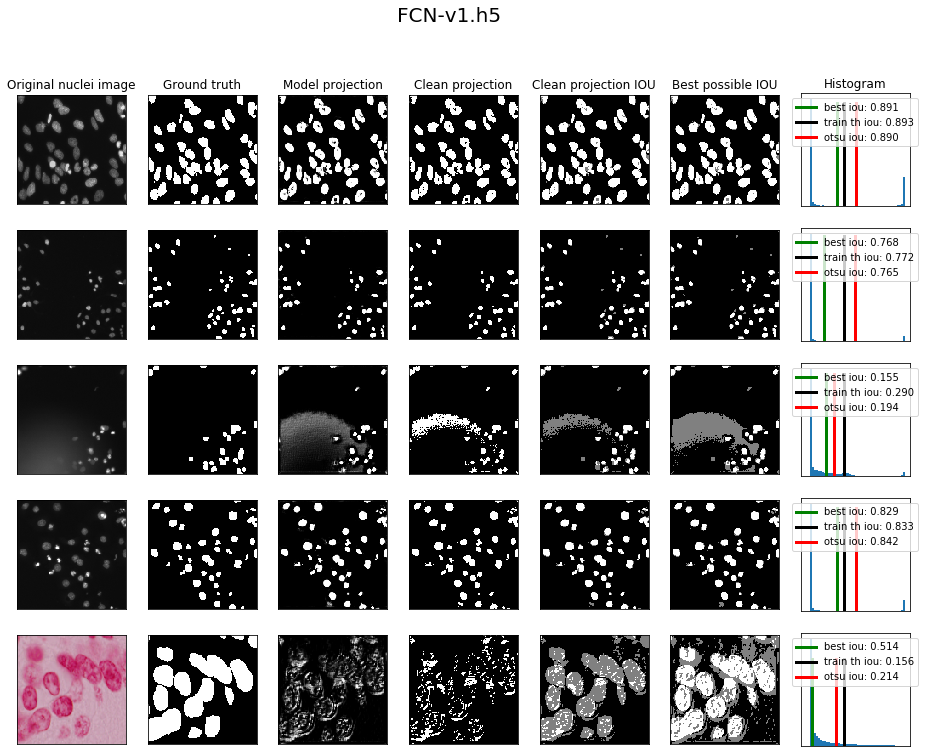

In [388]:
model_name = 'FCN-v1.h5'
investigate_iou(model_name)

## Predict on Unet

start investigate_iou:  U-net-v1.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 9s 17ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.5182763327672262  number of samples:  100
mean train IOU:  0.5676616699200134  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7480991790571201  number of samples:  100
mean train IOU:  0.6897966823568581  number of samples:  570

train threshold:  0.38366666666666627  test threshold:  0.4169999999999998

 best traning threshold to use:  0.4169999999999998

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7562097812133967  number of samples:  100
mean train IOU:  0.6900213926660126  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


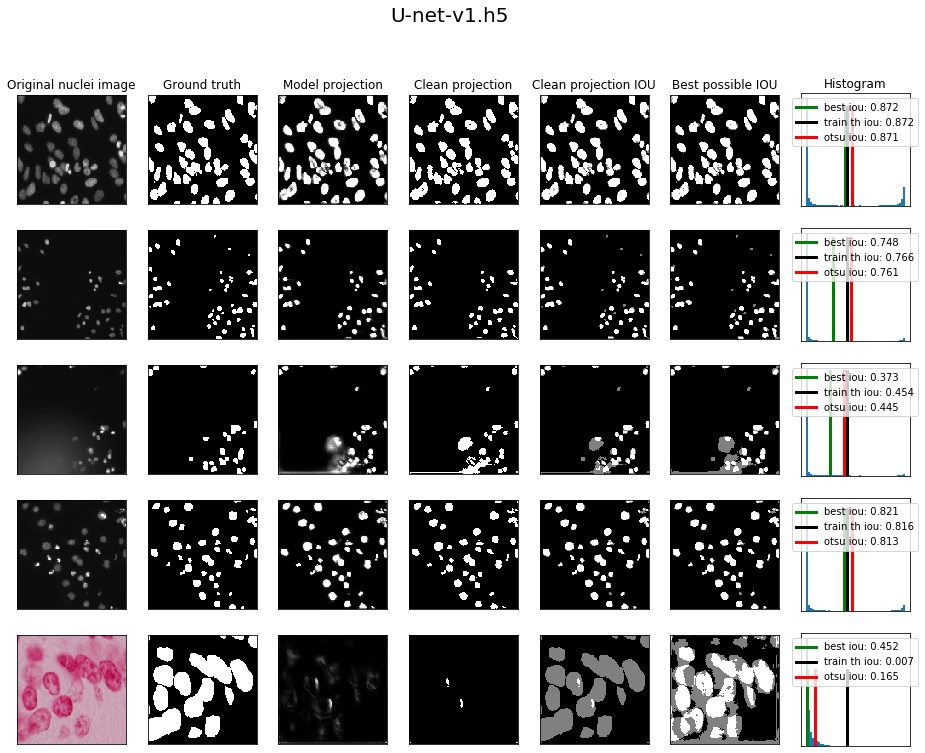

In [389]:
model_name = 'U-net-v1.h5'
investigate_iou(model_name)

start investigate_iou:  U-net-v1.h5


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 18ms/step

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7480991790571201  number of samples:  100
mean train IOU:  0.6897966823568581  number of samples:  570

train threshold:  0.38366666666666627  test threshold:  0.4169999999999998

 best traning threshold to use:  0.38366666666666627

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7538473424302264  number of samples:  100
mean train IOU:  0.6890911817049657  number of samples:  570


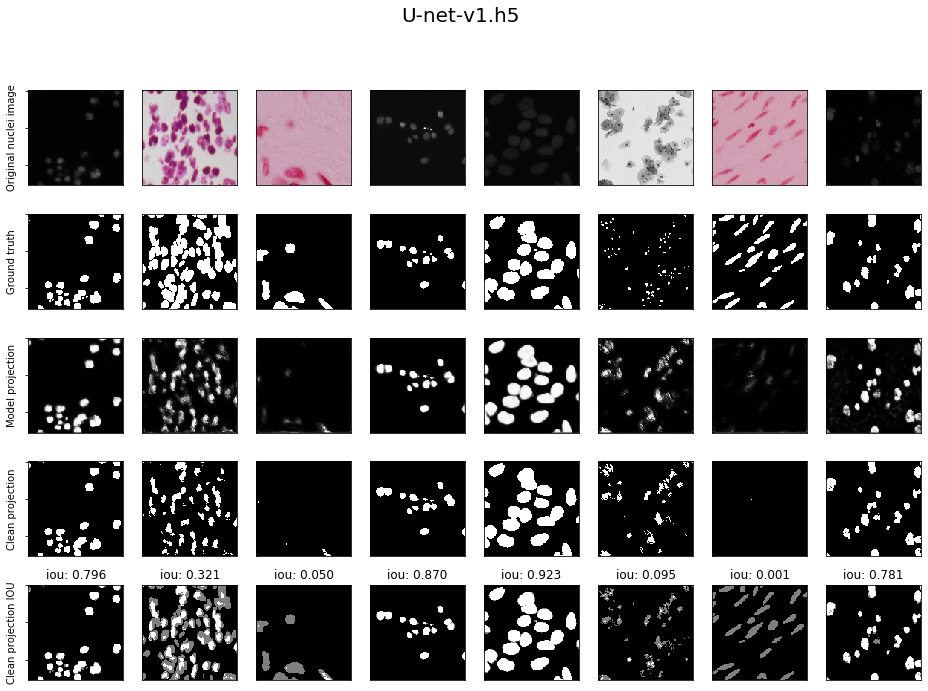

In [555]:
model_name = 'U-net-v1.h5'
investigate_iou(model_name)

start investigate_iou:  U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 17ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.3842971634035346  number of samples:  100
mean train IOU:  0.3715456878498074  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7001405403254165  number of samples:  100
mean train IOU:  0.664708466043612  number of samples:  570

train threshold:  0.3461754385964907  test threshold:  0.3708000000000001

 best traning threshold to use:  0.3708000000000001

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7517507079898419  number of samples:  100
mean train IOU:  0.6973512823774992  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


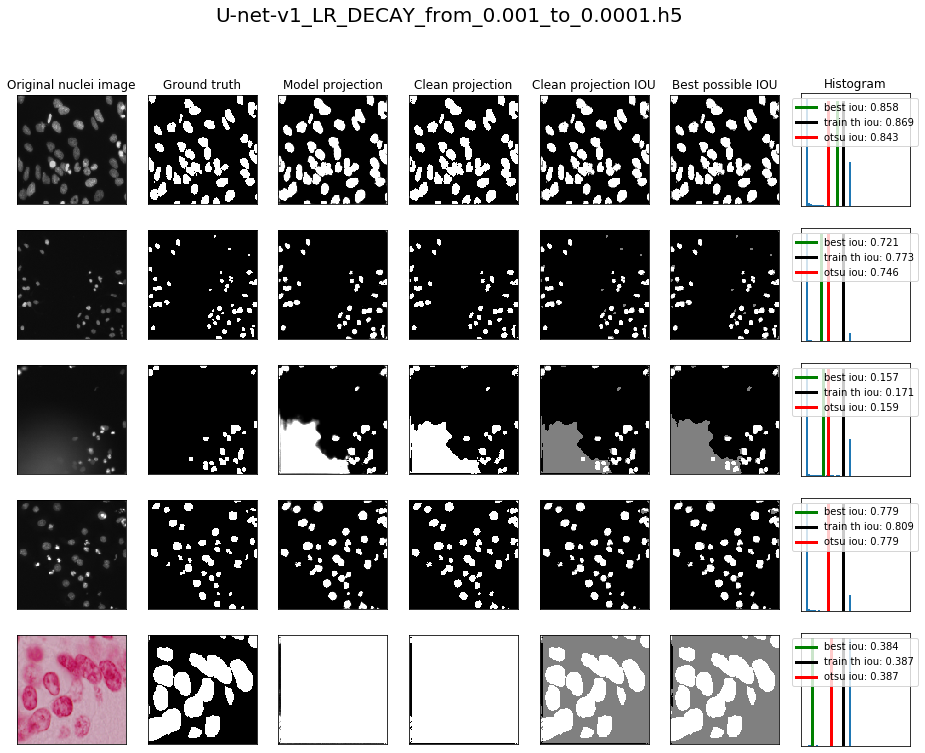

In [385]:
model_name = 'U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5'
investigate_iou(model_name)

start investigate_iou:  U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
570/570 [==============================] - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 12s 22ms/step

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7001405403254165  number of samples:  100
mean train IOU:  0.664708466043612  number of samples:  570

train threshold:  0.3461754385964907  test threshold:  0.3708000000000001

 best traning threshold to use:  0.3461754385964907

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7481098586218558  number of samples:  100
mean train IOU:  0.694270810722794  number of samples:  570


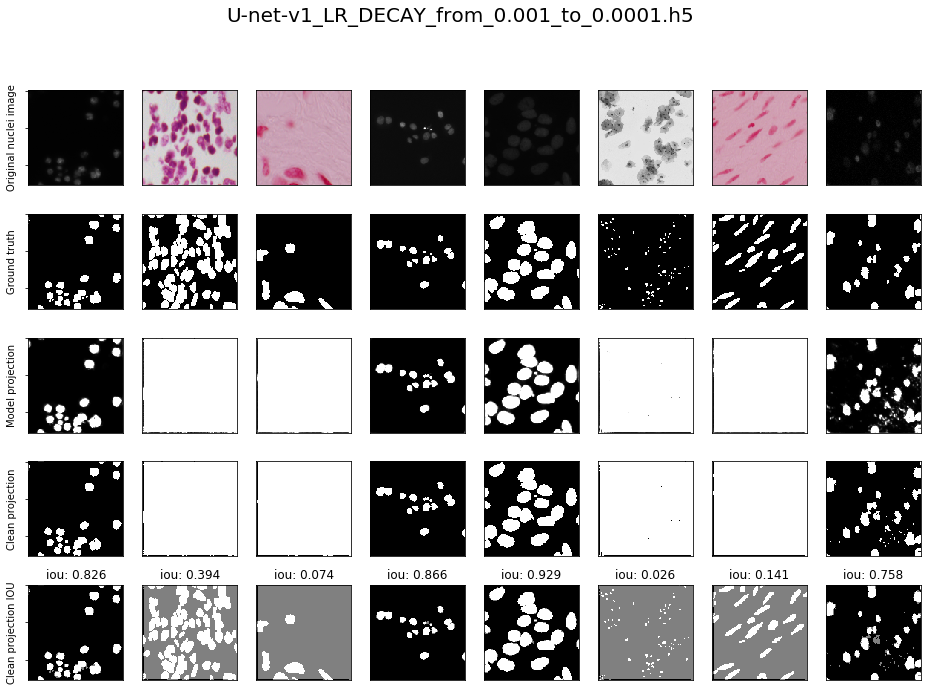

In [556]:
model_name = 'U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5'
investigate_iou(model_name)

## Predict on large Unet

start investigate_iou:  large-U-net-v1.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 17ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.6882451893809877  number of samples:  100
mean train IOU:  0.6873115712258251  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7379466157505038  number of samples:  100
mean train IOU:  0.6932102478642891  number of samples:  570

train threshold:  0.41480701754385857  test threshold:  0.4206999999999999

 best traning threshold to use:  0.4206999999999999

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7545533797687817  number of samples:  100
mean train IOU:  0.724690373798156  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


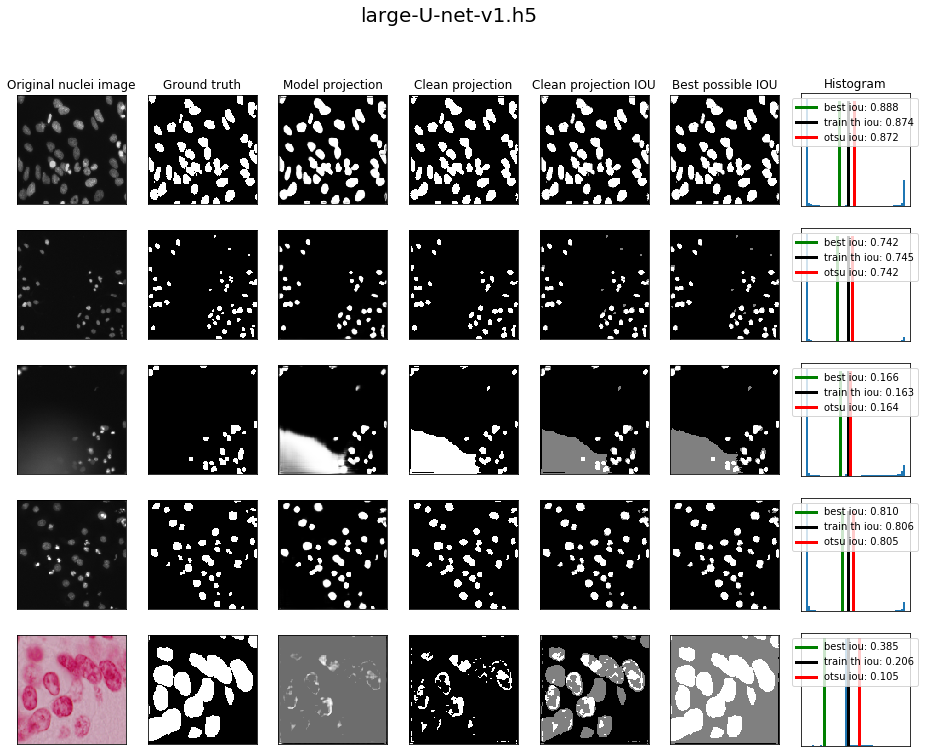

In [390]:
model_name = 'large-U-net-v1.h5'
investigate_iou(model_name)

start investigate_iou:  large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
570/570 [==============================] - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 18ms/step

 yen threshold, clean projection mean iou: 
mean test IOU:  0.5044994563878877  number of samples:  100
mean train IOU:  0.5458716957925654  number of samples:  570

 otsu threshold, clean projection mean iou: 
mean test IOU:  0.7590323589627497  number of samples:  100
mean train IOU:  0.70332340363824  number of samples:  570

train threshold:  0.4555087719298244  test threshold:  0.49229999999999974

 best traning threshold to use:  0.49229999999999974

 best traning threshold, clean projection mean iou: 
mean test IOU:  0.7665999934219968  number of samples:  100
mean train IOU:  0.7041319281375675  number of samples:  570


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


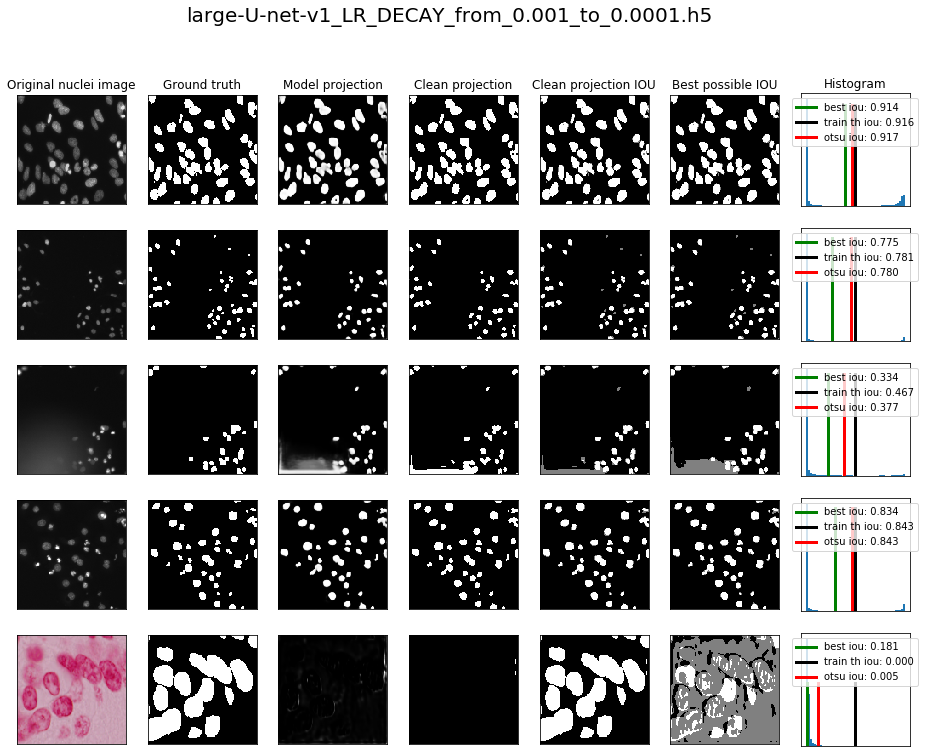

In [386]:
model_name = 'large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5'
investigate_iou(model_name)

In [391]:
model_name = 'NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5'
investigate_iou(model_name)

start investigate_iou:  NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 18ms/step


C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\skimage\filters\thresholding.py:347: RuntimeWarning: divide by zero encountered in reciprocal
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\skimage\filters\thresholding.py:348: RuntimeWarning: invalid value encountered in multiply
  (P1[:-1] * (1.0 - P1[:-1])) ** 2)



 yen threshold, clean projection mean iou: 
mean test IOU:  0.057886665521135194  number of samples:  100
mean train IOU:  0.06078994681516989  number of samples:  570


ValueError: threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 0.15492115914821625.

# Investigating Encoding

In [557]:
encoder = load_model("encoder_large_unet_v2_LR0.001.h5")

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [558]:
encoded_imgs = encoder.predict(X_train)
# decoded_imgs = decoder.predict(encoded_imgs)

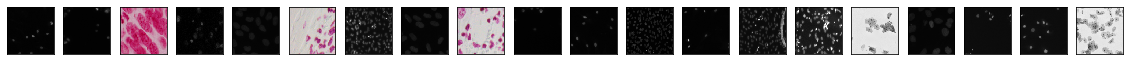

In [559]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(X_train[index])
    remove_axis(axarr[i])

plt.show()

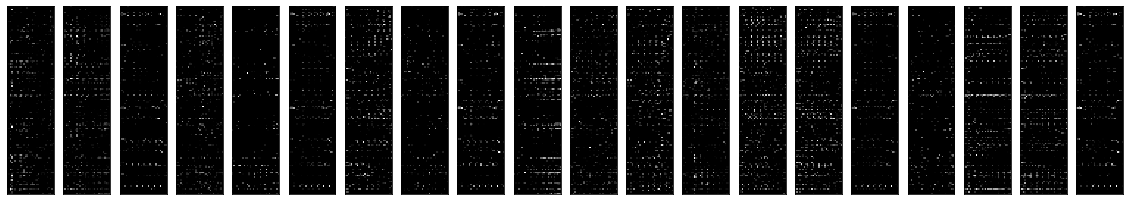

In [560]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(a)
    remove_axis(axarr[i])

plt.show()

In [561]:
encoded_imgs.shape

(570, 8, 8, 64)

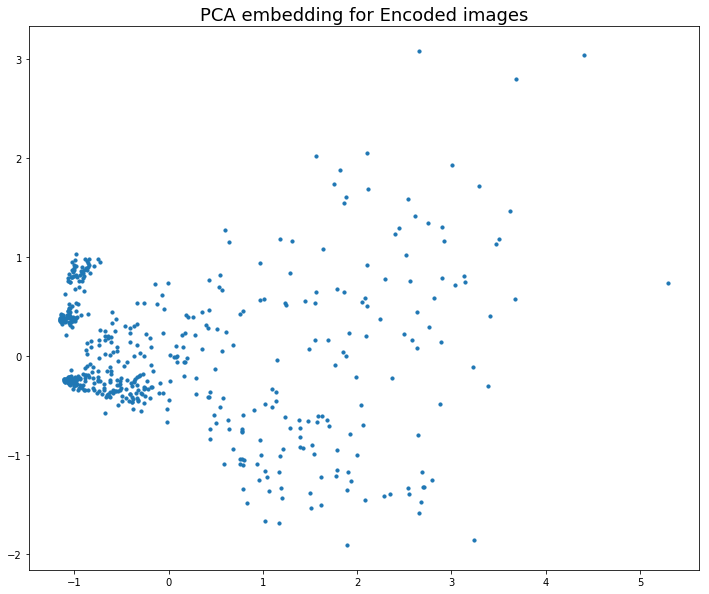

In [562]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform([x.reshape(4096) for x in encoded_imgs])
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=10)
plt.title("PCA embedding for Encoded images", fontsize=18)
plt.show()

In [563]:
embedding = umap.UMAP(n_neighbors=3, metric='correlation').fit_transform([x.reshape(4096) for x in encoded_imgs])

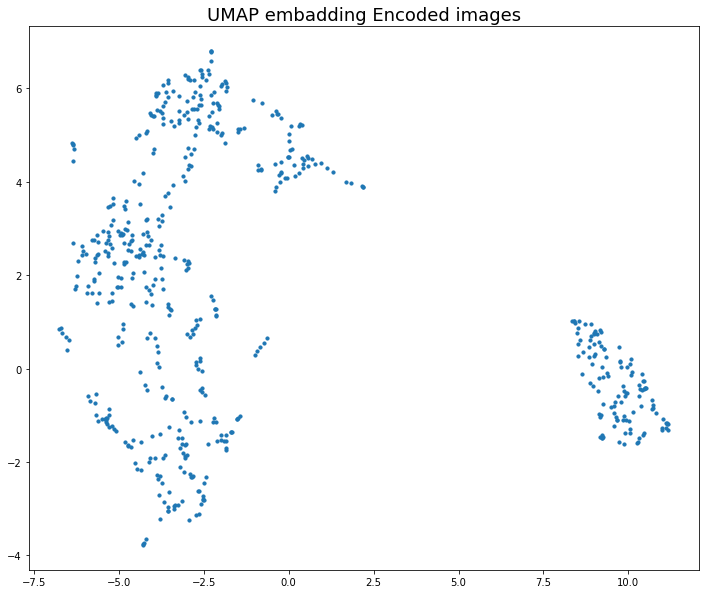

In [564]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.title("UMAP embadding Encoded images", fontsize=18)
plt.show()

In [565]:
db = DBSCAN(eps=0.7,  min_samples=10).fit(embedding)

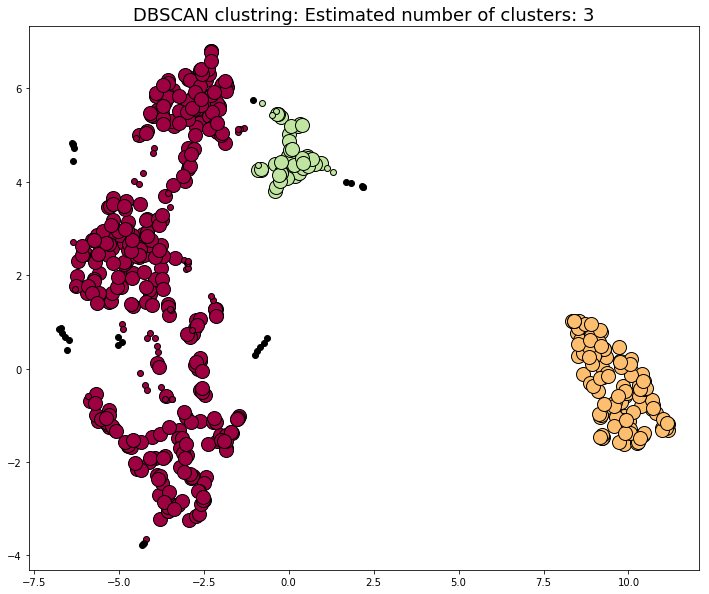

In [566]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig, ax = plt.subplots(figsize=(12, 10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embedding[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustring: Estimated number of clusters: %d' % n_clusters_, fontsize=18)
plt.show()

In [567]:
def scatter_images_plot(images, embedding, unique_labels, colors, labels, title = "UMAP embedding of images"):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = offsetbox.OffsetImage(img0, zoom=zoom)
            ab = offsetbox.AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs):
        fig, ax = plt.subplots(figsize=(20, 20))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.35, ax=ax)
            

    plot_embedding(embedding, X_train)
    plt.title(title, fontsize=20)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        class_member_mask = (labels == k)
        xy = embedding[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=75)

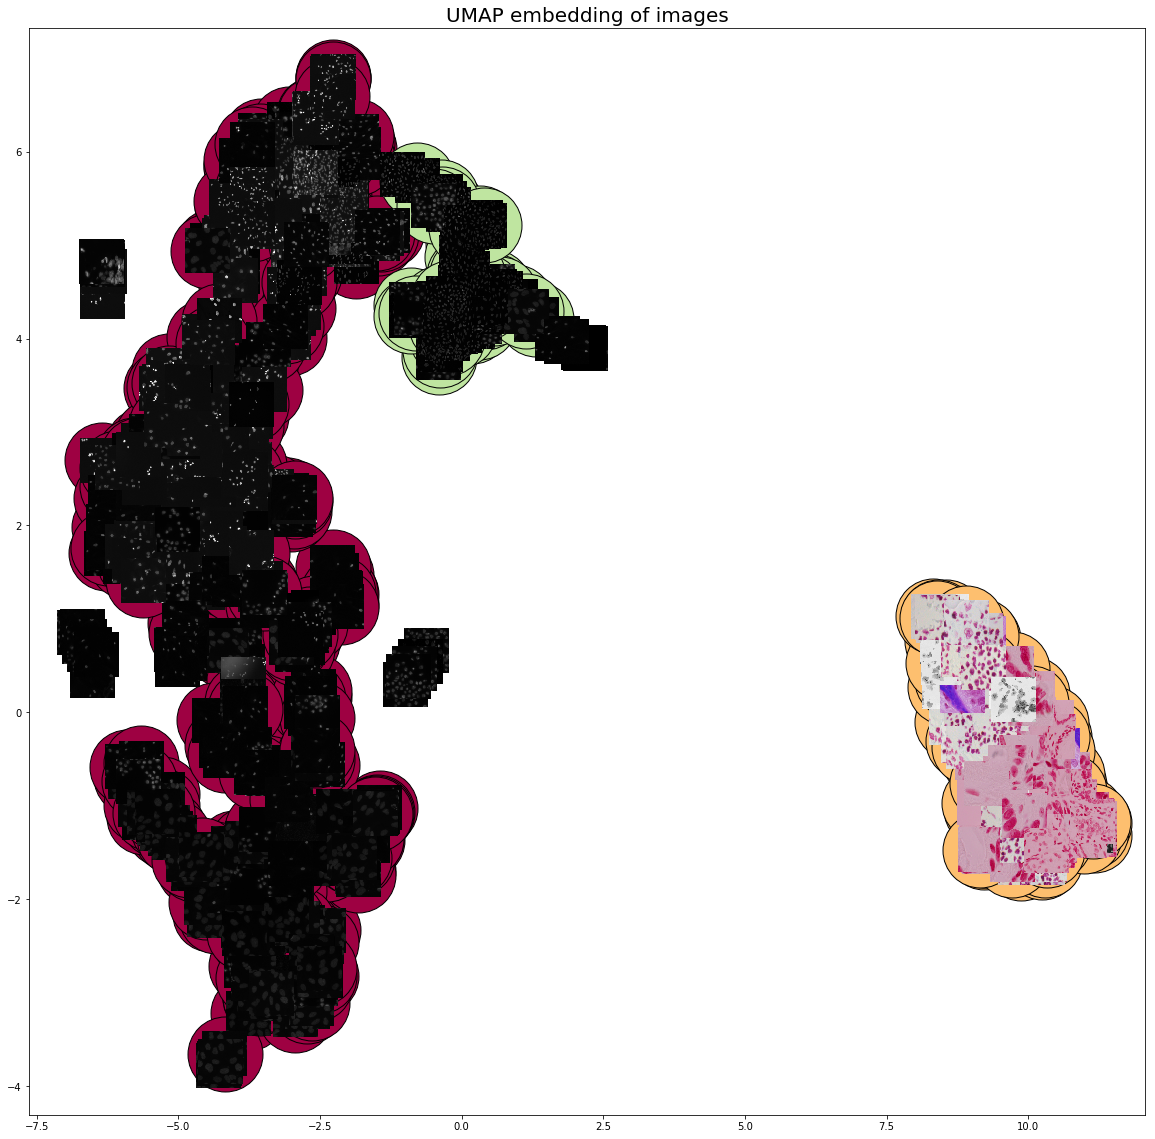

In [568]:
scatter_images_plot(X_train, embedding, unique_labels, colors, labels)

start investigate_encoding:  encoder_BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5


C:\Users\Sharon\Anaconda3\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


start umap embedding...
start DBSCAN...


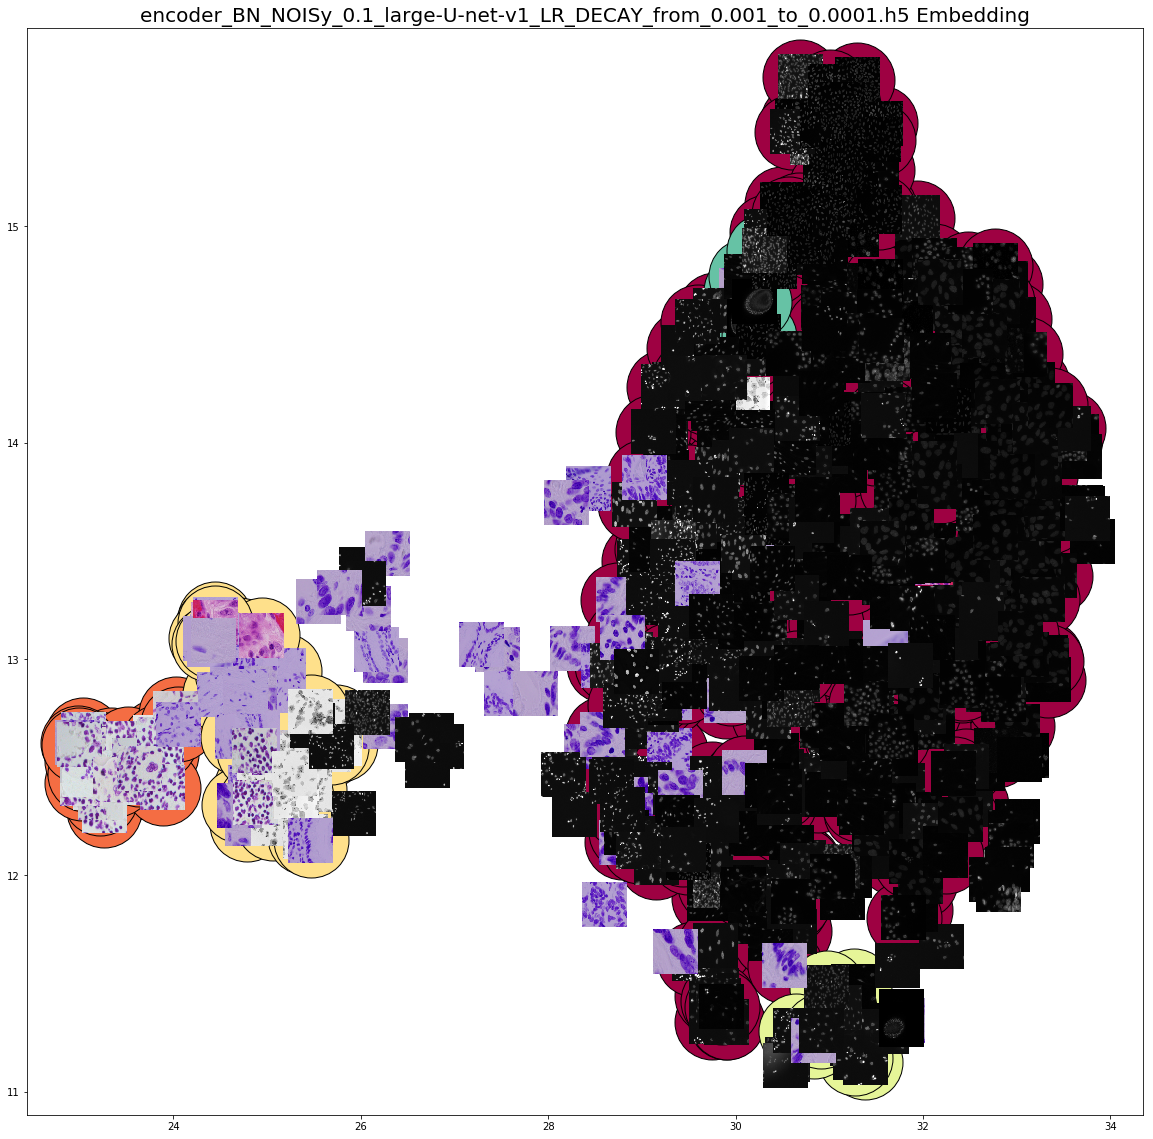

In [144]:
encoder_name = "encoder_BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"
investigate_encoding(encoder_name)

# Denoising 

In [627]:
x_train_vec = X_train.astype('float32') / 255.
x_test_vec = X_test.astype('float32') / 255.
x_train_vec = x_train_vec.reshape((len(x_train_vec), np.prod(x_train_vec.shape[1:])))
x_test_vec = x_test_vec.reshape((len(x_test_vec), np.prod(x_test_vec.shape[1:])))
print(x_train_vec.shape)
print(x_test_vec.shape)

(570, 49152)
(100, 49152)


In [641]:
a = (x_train_vec[0]+ 0.2* np.random.normal(loc=0.0, scale=256.0, size=x_train_vec[0].shape))/256
a = np.clip(a, 0., 1.)
a = a.reshape(128, 128, 3)

(128, 128, 3)


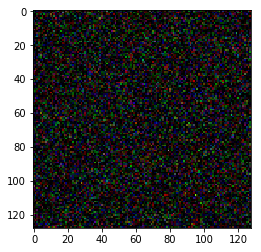

In [642]:
print(a.shape)
plt.imshow(a)


In [643]:
 a = (X_test+ 0.2* np.random.normal(loc=0.0, scale=256.0, size=X_test.shape))/256

(100, 128, 128, 3)


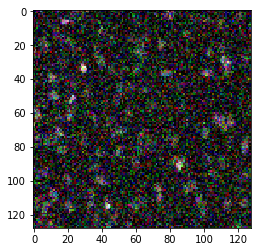

In [646]:
plt.imshow(a[1])
print(a.shape)

In [663]:
def get_noisy_data(noise_factor = 0.01):
    x_train_noisy = (X_train+ noise_factor* np.random.normal(loc=0.0, scale=256.0, size=X_train.shape))
    x_test_noisy = (X_test+ noise_factor* np.random.normal(loc=0.0, scale=256.0, size=X_test.shape))
    return x_train_noisy, x_test_noisy

In [667]:
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor = 0.01)

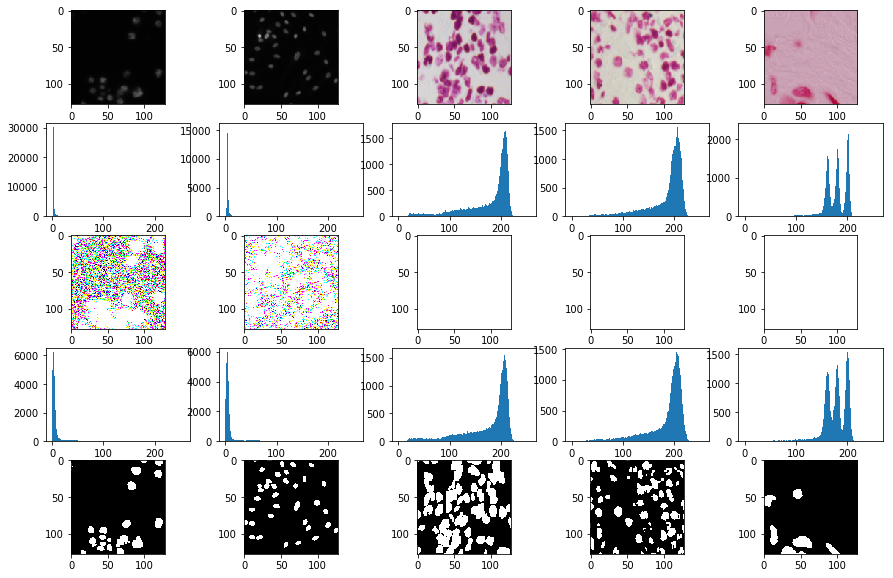

In [668]:
n = 5
f, axarr = plt.subplots(5,n,figsize=(15,10))
for i in range(n):
    axarr[0, i].imshow(X_train[i])
    
    axarr[1,i].hist(X_train[i].ravel(), bins=256, range=(0.0, 256.0))
    axarr[2, i].imshow(x_train_noisy[i])
    axarr[3, i].hist(x_train_noisy[i].ravel(), bins=256, range=(0.0, 256.0))
    axarr[4, i].imshow(np.squeeze(Y_train[i]))
#     for j in range(0,3):
#         remove_axis(axarr[j, i])

    
plt.show()

In [ ]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "noisy_large_unet_v3_LR{}.h5".format(START_LR)

epochs_=100

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    
results = model.fit(x_train_noisy, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochs_, 
                    verbose=0,
                    callbacks=[earlystopper, checkpointer])

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\envs\sharon_env2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 00001: val_loss improved from inf to 0.43427, saving model to noisy_large_unet_v3_LR0.001.h5

Epoch 00002: val_loss improved from 0.43427 to 0.36656, saving model to noisy_large_unet_v3_LR0.001.h5

Epoch 00003: val_loss improved from 0.36656 to 0.21082, saving model to noisy_large_unet_v3_LR0.001.h5

Epoch 00004: val_loss improved from 0.21082 to 0.18759, saving model to noisy_large_unet_v3_LR0.001.h5

Epoch 00005: val_loss improved from 0.18759 to 0.17388, saving model to noisy_large_unet_v3_LR0.001.h5


In [ ]:
f, axarr = plt.subplots(1,2,figsize=(12,4))
for i, train_v, test_v, metric in [(0, 'acc','val_acc', 'accuracy'),(1, 'loss', 'val_loss', 'loss')]:
    axarr[i].plot(results2.history[train_v])
    axarr[i].plot(results2.history[test_v])
    axarr[i].set_title('model {}'.format(metric))
    axarr[i].set_ylabel(metric)
    axarr[i].set_xlabel('epoch')
    axarr[i].legend(['train', 'test'], loc='upper left')

In [ ]:
model_name = 'noisy_large_unet_v2_LR0.001.h5'
investigate_iou(model_name)

## Training denoising unet

In [278]:
def train_noisy_model(x_train_noisy, noise_factor, epochs_):
    model, encoder, decoder = large_unet()

    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "NOISy{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[checkpointer])
    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [43]:
for noise_factor in [0.1, 0.2, 0.3, 0.4, 0.5]:
    x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
    train_noisy_model(x_train_noisy,noise_factor, epochs_ = 20)

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.44122, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.44122 to 0.43968, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43968 to 0.43284, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43284 to 0.43038, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43038 to 0.42961, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.42961 to 0.42733, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss improved from 0.42733 to 0.42452, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss imp

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_3, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.67165, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67165 to 0.65171, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65171 to 0.63289, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63289 to 0.61559, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61559 to 0.59948, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59948 to 0.58468, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58468 to 0.57113, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57113 to 0.55858, saving model to NOISy0.2_large-U-net-v1_LR_DE

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_4, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.43648, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43648 to 0.43611, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43611 to 0.43079, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.43079 to 0.43041, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.43041 to 0.42957, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.42957 to 0.42916,

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_5, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.44155, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.44155 to 0.43658, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43658 to 0.43344, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43344 to 0.43120, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43120 to 0.43092, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.43092 to 0.42954, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss did not improve
Ep

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_6, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.43905, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.43905 to 0.43255, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43255 to 0.43201, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43201 to 0.43072, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43072 to 0.42788, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.42788 to 0.42578, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss improved from 0.42578 to 0.42453, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did

In [279]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.65373, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.65373 to 0.57656, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.57656 to 0.48817, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.48817 to 0.44174, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.44174 to 0.43239, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.43239 to 0.43172, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43172 to 0.43167, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.43167 to 0.43166, saving model to NOISy0.1_large-U-net-v1_LR_DE

In [280]:
noise_factor = 0.125
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67163, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67163 to 0.65141, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65141 to 0.63263, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63263 to 0.61524, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61524 to 0.59895, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59895 to 0.58441, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58441 to 0.57055, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57055 to 0.55785, saving model to NOISy0.125_larg

In [ ]:
noise_factor = 0
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67122, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67122 to 0.65101, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65101 to 0.63238, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63238 to 0.61518, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61518 to 0.59915, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59915 to 0.58435, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58435 to 0.57050, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57050 to 0.55790, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_t

In [149]:
noise_factor = 0.05
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67143, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67143 to 0.65146, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65146 to 0.63283, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63283 to 0.61542, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61542 to 0.59918, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59918 to 0.58446, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58446 to 0.57078, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57078 to 0.55812, saving model to NOISy0.05_large-U-net-

In [ ]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 200)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67140, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67140 to 0.65125, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65125 to 0.63263, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63263 to 0.61518, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61518 to 0.59915, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59915 to 0.58436, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58436 to 0.57056, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57056 to 0.55791, saving model to NOISy0.1_large-U-net-v1_LR_DE

In [50]:
noise_factor = 0.45
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.48303, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.48303 to 0.44952, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.44952 to 0.43788, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43788 to 0.43463, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.43463 to 0.43453, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00012: val_loss improved from 0.43453 to 0.43437, saving model to NOISy0.45_large-

## Training denoising with batch normalization

In [43]:
def bn_large_unet(input_size = (128,128,3)):

    inputs = Input(input_size)
    
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    lambda1 = BatchNormalization()(lambda1)
    
    contract4, conv4 = Contracting(lambda1, 4)
    contract4 = BatchNormalization()(contract4)
    conv4 = BatchNormalization()(conv4)
    
    contract8, conv8 = Contracting(contract4, 8)
    contract8 = BatchNormalization()(contract8)
    conv8 = BatchNormalization()(conv8)
    
    contract16, conv16 = Contracting(contract8, 16)
    contract16 = BatchNormalization()(contract16)
    conv16 = BatchNormalization()(conv16)    
    
    contract32, conv32 = Contracting(contract16, 32)
    contract32 = BatchNormalization()(contract32)
    conv32 = BatchNormalization()(conv32)   
    
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    convolve_n_drop64 = BatchNormalization()(convolve_n_drop64)   
    
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan32 = BatchNormalization()(expan32)   
    
    expan16 = Expansive(expan32, conv16, 16)
    expan16 = BatchNormalization()(expan16)     
    
    expan8 = Expansive(expan16, conv8, 8)
    expan8 = BatchNormalization()(expan8)  
    
    expan4 = Expansive(expan8, conv4, 4)
    expan4 = BatchNormalization()(expan4)  
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)

    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [44]:
def train_bn_noisy_model(x_train_noisy, noise_factor, epochs_):
    model, encoder, decoder = bn_large_unet()

    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "BN_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[checkpointer])
    print(results)
    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [60]:
noise_factor = 0.15
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67380, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.67380 to 0.56179, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.56179 to 0.55952, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.55952 to 0.49948, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.49948 to 0.32473, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.32473 to 0.17402, saving model

In [61]:
noise_factor = 0.1
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.44732, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.44732 to 0.40977, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.40977 to 0.38723, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss improved from 0.38723 to 0.14249, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00012: val_loss improved from 0.14249 to 0.13228, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00013: val_loss did not impro

### using batch size 32

In [56]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)

model, encoder, decoder = bn_large_unet()

model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "BN_e32_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
results = model.fit(x_train_noisy, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=0,
                    callbacks=[checkpointer])
print(results)
decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.61622, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.61622 to 0.57416, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.57416 to 0.46756, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.46756 to 0.43644, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve


KeyboardInterrupt: 

## Training denoiser with BN and leaky relu activation

In [45]:
def batch_leaky_conv2d(inputs, dim, kernel_size):
    conv = Conv2D(dim, kernel_size, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
    return conv

def Contracting_leaky(inputs, dim):
    conv = batch_leaky_conv2d(inputs, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return pool , conv

def Expansive_leaky(inputs, parallel_conv, dim):
    up = UpSampling2D(size = (2,2))(inputs)
    up = batch_leaky_conv2d(up, dim, 2)
    merge_l = concatenate([parallel_conv,up], axis=3)
    conv = batch_leaky_conv2d(merge_l, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    return conv

def Conv_n_Dropout_leaky(inputs, dim):
    conv = batch_leaky_conv2d(inputs, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    drop = Dropout(0.5 ,  name='decoder')(conv)
    return drop
    

In [46]:
def bn_leaky_large_unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting_leaky(lambda1, 4)
    contract8, conv8 = Contracting_leaky(contract4, 8)
    contract16, conv16 = Contracting_leaky(contract8, 16)  
    contract32, conv32 = Contracting_leaky(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout_leaky(contract32, 64)
    expan32 = Expansive_leaky(convolve_n_drop64, conv32, 32)
    expan16 = Expansive_leaky(expan32, conv16, 16)
    expan8 = Expansive_leaky(expan16, conv8, 8)
    expan4 = Expansive_leaky(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)

    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [ ]:
def train_leaky_bn_noisy_model(x_train_noisy, noise_factor, epochs_):
    
    model, encoder, decoder = bn_leaky_large_unet()
    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "BN_LEAKY_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        shuffle=True, 
                        verbose=0,
                        callbacks=[checkpointer])

    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [49]:
noise_factor = 0.125
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.46508, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.46508 to 0.43926, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43926 to 0.34571, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.34571 to 0.19785, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss 

KeyboardInterrupt: 

In [51]:
noise_factor = 0.45
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)


C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.46514, saving model to BN_LEAKY_NOISy_0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.46514 to 0.41825, saving model to BN_LEAKY_NOISy_0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve
Epoch 00020: val_loss did not improve
Ep

In [52]:
noise_factor = 0.1
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.66778, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.66778 to 0.64173, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.64173 to 0.60414, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.60414 to 0.59730, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.59730 to 0.49529, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.49529 to 0.43392, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_l

In [53]:
noise_factor = 0.11
epoches = 150
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.66853, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.66853 to 0.48072, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.48072 to 0.43873, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: v

In [54]:
Y_train.shape

(570, 128, 128, 1)

In [55]:
X_train.shape

(570, 128, 128, 3)

# Convolutional autoencoder

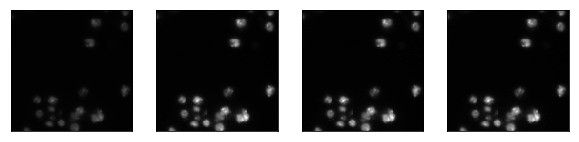

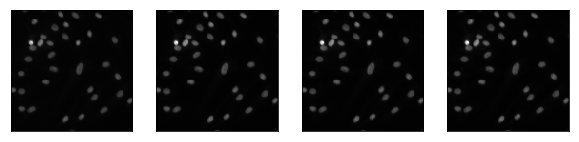

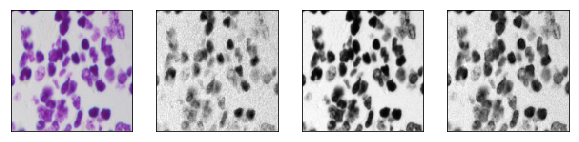

In [270]:
def plot_RGB(image):
    b = image.copy()[:, :, 0]
    g = image.copy()[:, :, 1]
    r = image.copy()[:, :, 2]
    
    f, axarr = plt.subplots(1,4,figsize=(10,5))
    axarr[0].imshow(image)
    axarr[1].imshow(r)
    axarr[2].imshow(g)
    axarr[3].imshow(b)
    for l in range(0,4):
        remove_axis(axarr[l])
        
for i in range(0,3):
    plot_RGB(X_train[i])

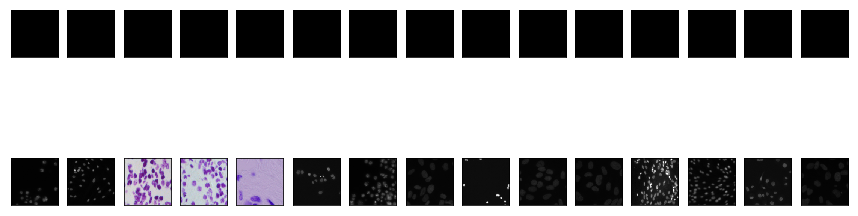

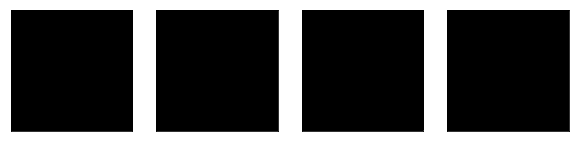

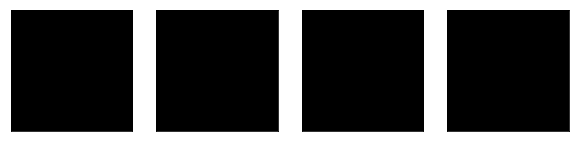

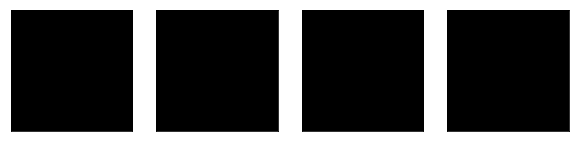

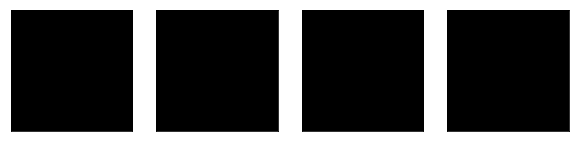

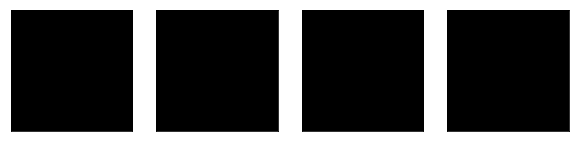

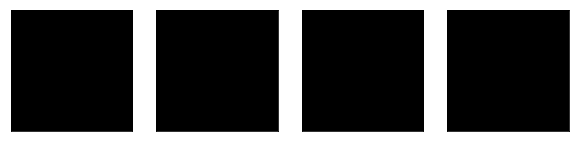

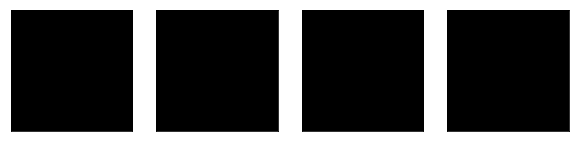

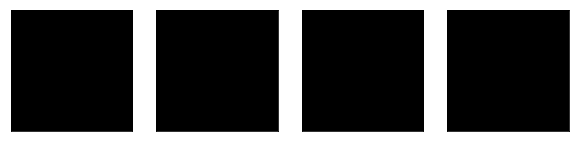

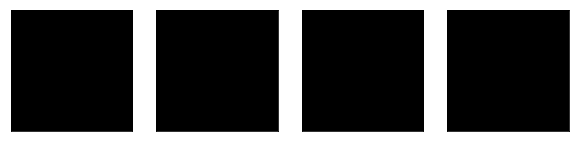

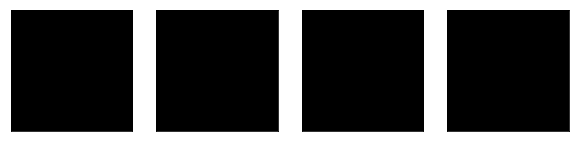

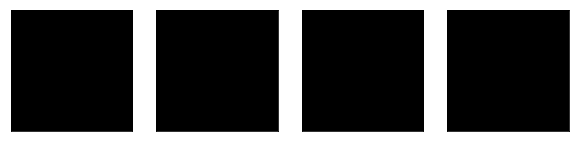

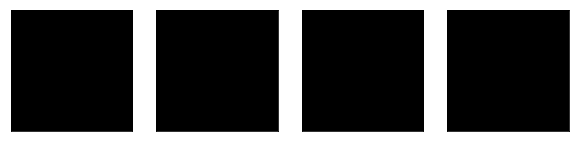

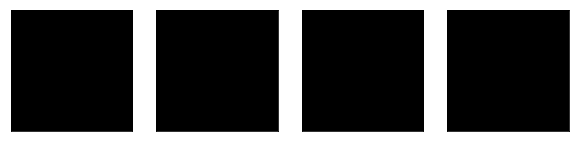

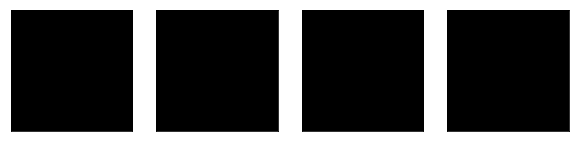

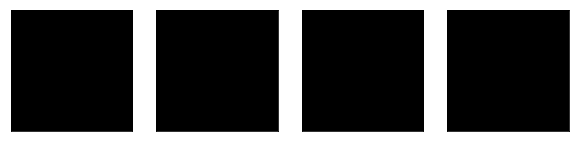

In [271]:
k = 15
f, axarr = plt.subplots(2,k,figsize=(k,5))
for i in range(0,k):
    axarr[0,i].imshow(preds_train[i])
    axarr[1,i].imshow(X_train[i])
    remove_axis(axarr[0,i])
    remove_axis(axarr[1,i])
    
    plot_RGB(preds_train[i])

In [272]:
def print_model(model_name):
    test_model_name = model_name
    model = load_model(test_model_name)
    preds_test = model.predict(X_test, verbose=1)
    preds_train = model.predict(X_train, verbose=1)
    best_th = 0.1
    f, axarr = predict_segmentetion_plot(model_name = "Unet")